## HOMEWORK 2

### Approssimazione dei dati

Scaricare tramite Virtuale il file data_hw.csv, inserirlo nella cartella del progetto (per esempio, supponiamo di inserirlo nel path relativo ./data/data_hw.csv), e caricarlo su Python (utilizzando pandas). Fatto ciò, il dataset si presenterà come un’array composto da 50 righe e 2 colonne. Le due colonne (chiamate x e y), indicano i valori in x e in y di una serie di dati (rumorosi) che si vuole analizzare. Sono note due informazioni sui dati in questione:

* La funzione che lega y ad x è un polinomio di un certo grado d_true, il cui valore non è noto.

* I dati in y sono corrotti da del rumore Gaussiano con una certa intensità sigma, anch’essa ignota.

In questo esercitazione si vuole approssimare y il meglio possibile, utilizzando le tecniche di approssimazione dati viste a lezione. Tenendo a mente quanto fatto nella rispettiva lezione,

* Visualizzare (tramite un plot) i dati. Stimare (tramite ragionamento) il possibile grado del polinomio che ha generato i dati.

* Scelta una stima d per il grado del polinomio, impostare il problema ai minimi quadrati.

  $$
  \min_{\alpha\in\R^{d+1}} \| X\alpha - y \|_2^2
  $$

  dove $ \alpha\in\R^{d+1} $ rappresenterà (una volta risolto) il vettore dei coefficienti del polinomio, mentre $ X\in\R^{n \times (d+1)} $ è la matrice di Vandermonde associata ad $ x $.

* Risolvere il problema ai minimi quadrati tramite metodo delle Equazioni Normali, utilizzando:

  * Il metodo di Cholesky (dopo aver controllato che la matrice ne soddisfa le ipotesi di applicabilità),
  
  * Soluzione tramite decomposizione SVD,
  
  * Algoritmo dei Gradienti Coniugati (CGLS). Confrontare i tre metodi misurando sia il tempo impiegato, che plottando (sullo stesso plot) i polinomi descritti dalla soluzione dei tre metodi, commentando su quale (a occhio) approssima meglio i dati.

* Ripetere l’esperimento sopra variando il grado d del polinomio approssimante in $ {1, 2, 3,..., 8} $. Per quale scelta di d il polinomio approssimante meglio approssima i dati?

* Per d = 6, impostare il problema ai minimi quadrati regolarizzato con Tikhonov,

  $$
  \min_{\alpha\in\R^{d+1}} \frac{1}{2}\| X\alpha - y \|_2^2 + \frac{\lambda}{2}\| Lx \|_2^2
  $$

  con $ L $ matrice identità, e $ \lambda > 0 $ parametro di regolarizzazione.

* Risolvere il problema ai minimi quadrati regolarizzato con Tikhonov utilizzando:

  * Il metodo di Cholesky (dopo aver controllato che la matrice ne soddisfa le ipotesi di applicabilità),

  * Soluzione tramite decomposizione SVD,

  * Algoritmo dei Gradienti Coniugati (CGLS). Visualizzare le soluzioni ottenute sul grafico al variare della scelta del parametro $ \lambda > 0 $. Per quale valore di $ \lambda $ il polinomio approssimante meglio approssima i dati?

* Ripetere l’esperimento sopra variando il grado d del polinomio approssimante.

* Ripetere l’esperimento sopra utilizzando come matrice di Tikhonov $ L $ la matrice:

  $$
  L = \begin{bmatrix}1&-1&0&0&\cdots&0\cr
                     0&1&-1&0&\cdots&0\cr
                     0&0&1&-1&\cdots&0\cr
                     0&0&0&1&\cdots&0\cr
                     \vdots&\vdots&\vdots&\vdots&\vdots&\vdots\cr
                     0&0&0&0&\cdots&-1\cr
                     0&0&0&0&\cdots&1\cr
      \end{bmatrix}
  $$

 
 
  ovvero la matrice (di dimensione $ n \times n$, dove $ n $ è uguale al numero di elementi di $ x $), che ha tutti valori $ 1 $ sulla diagonale, e valori $ -1 $ sulla sovra-diagonale. Come cambiano i risultati precedenti per questa scelta di $ L $?

* Sapendo ora che d_true = 4 e alpha_true = np.array([0, 0, 4, 0, -3]), misurare (per alcuni degli esperimenti fatti sopra (i più promettenti)) l’errore relativo tra il valore di alpha calcolato e alpha_true, e confrontare visivamente su grafico i polinomi approssimanti rispetto al polinomio reale (senza rumore) ottenuto tramite alpha_true. Commentare i risultati ottenuti.

#### SOLUZIONE:

Partiamo dal primo punto e carichiamo e visualizziamo i dati usando la libreria pandas.

In [258]:
import pandas as pd

data_path = "./data_hw.csv"
data = pd.read_csv(data_path)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  50 non-null     int64  
 1   x           50 non-null     float64
 2   y           50 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.3 KB
None


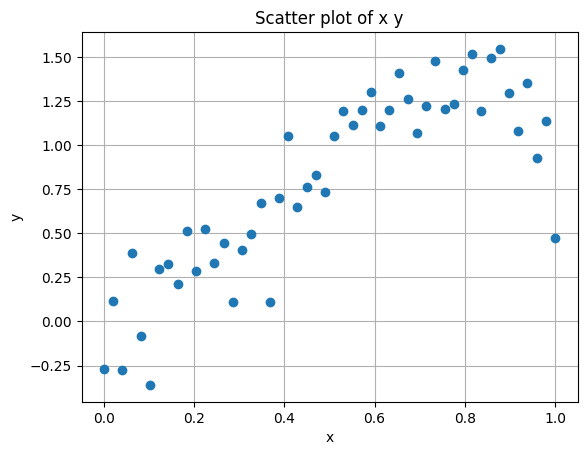

In [259]:
import numpy as np
import matplotlib.pyplot as plt

x: np.ndarray = np.array(data["x"])
y: np.ndarray = np.array(data["y"])

plt.plot(x, y, "o", label="Data points")
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Scatter plot of x y")
plt.show()

Dal grafico possiamo notare che i punti non seguono un andamento lineare ma hanno una crescita iniziale e un leggero declino finale verso $ x = 0.8 $. Questo cambio di curvatura suggerisce la presenza di termini di grado superiore al primo. 

Scegliamo $ d = 2 $ come stima iniziale e impostiamo il problema ai minimi quadrati.

In [260]:
d: int = 2

TOL = 1e-10
MAX_ITER = 1000

Definiamo la matrice Valdemonde

In [261]:
def vandermonde(x: np.ndarray, d: int) -> np.ndarray:
    r"""
    Preso in input un numpy array "x" di lunghezza (n, ) contentente i dati, e un valore intero "d" rappresentante il grado del polinomio, 
    costruisce e ritorna la matrice di vandermonde X di grado d, associata a x.

    Parameters:
    x (ndarray): Il vettore dei dati di input.
    d (int): Il grado massimo del polinomio.

    Returns:
    X (ndarray): La matrice di Vandermonde di grado "d", associata ad x.
    """
    n = x.shape[0]
    X = np.zeros((n, d+1))
    
    for i in range(d+1):
        X[:, i] = x ** i
    return X

Definiamo le funzioni dei metodi per risolvere il problema ai minimi quadrati:
1. Cholesky
2. SVD
3. Gradienti Coniugati (CGLS)

#### 1. Cholesky

In [262]:
def solve_cholesky(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Risolve usando la decomposizione di Cholesky.
    
    Parameters:
    X (np.ndarray): Matrice delle caratteristiche (features).
    y (np.ndarray): Vettore delle risposte (target).
    
    Returns:
    np.ndarray: Vettore dei pesi (coefficients) della regressione lineare.
    """
    rank = np.linalg.matrix_rank(X)
    if rank < X.shape[1]:
        raise ValueError("La matrice X non ha rango pieno.")
    
    A = X.T @ X
    b = X.T @ y
    L = np.linalg.cholesky(A)
    z = np.linalg.solve(L, b)
    x = np.linalg.solve(L.T, z)
    
    return x

#### 2. SVD

In [263]:
def solve_svd(X: np.ndarray, y: np.ndarray, d: int) -> np.ndarray:
    """
    Risolve usando la decomposizione SVD.
    
    Parameters:
    X (np.ndarray): Matrice delle caratteristiche (features).
    y (np.ndarray): Vettore delle risposte (target).
    d (int): Numero di caratteristiche (features).
    
    Returns:
    np.ndarray: Vettore dei pesi (coefficients) della regressione lineare.
    """
    U, s, VT = np.linalg.svd(X, full_matrices=False)
    x = np.zeros(d+1)
    
    for i in range(d+1):
        x = x + (U[:, i].T @ y) / s[i] * VT[i, :]

    return x

#### 3. Gradienti Coniugati (CGLS)

In [264]:
def solve_cgls(X: np.ndarray, y: np.ndarray, atol: float = TOL, max_iter: int = MAX_ITER) -> np.ndarray:
    """
    Risolve usando il metodo Conjugate Gradient Least Squares (CGLS).
    
    Parameters:
    X (np.ndarray): Matrice delle caratteristiche (features).
    y (np.ndarray): Vettore delle risposte (target).
    tol (float): Tolleranza per la convergenza.
    max_iter (int): Numero massimo di iterazioni.
    
    Returns:
    np.ndarray: Vettore dei pesi (coefficients) della regressione lineare.
    """
    m, n = X.shape
    x = np.zeros(n)
    r = y - X @ x
    s = X.T @ r
    p = s.copy()
    norm_r0 = np.linalg.norm(r)
    
    for k in range(max_iter):
        q = X @ p
        alpha = (s.T @ s) / (q.T @ q)
        x = x + alpha * p
        r = r - alpha * q
        s_new = X.T @ r
        
        if np.linalg.norm(r) < atol * norm_r0:
            print(f"CGLS converged in {k+1} iterations.")
            break
        
        beta = (s_new.T @ s_new) / (s.T @ s)
        p = s_new + beta * p
        s = s_new
        
    return x

Impostiamo il problema, risolviamolo con i vari metodi e confrontiamo i risultati.

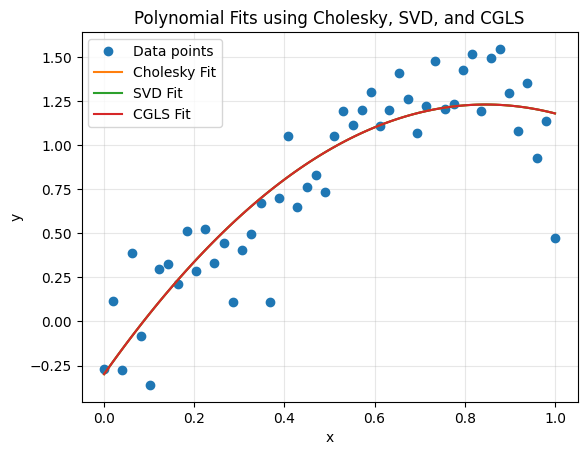

,Method,Coefficients,Time
0,Cholesky,"[-0.299029661402, 3.6188454860525, -2.1381178732308]",0.000483
1,SVD,"[-0.299029661402, 3.6188454860524, -2.1381178732307]",0.001153
2,CGLS,"[-0.299029661402, 3.6188454860523, -2.1381178732307]",0.058767


In [269]:
import time

X = vandermonde(x, d)

def timed(func):
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        elapsed_time = time.perf_counter() - start_time
        return result, elapsed_time
    return wrapper

solve_cholesky_timed = timed(solve_cholesky)
solve_svd_timed = timed(solve_svd)
solve_cgls_timed = timed(solve_cgls)

cholesky_result, cholesky_time = solve_cholesky_timed(X, y)
svd_result, svd_time = solve_svd_timed(X, y, d)
cgls_result, cgls_time = solve_cgls_timed(X, y)

xx = np.linspace(x.min(), x.max(), 100)

plt.plot(x, y, "o", label="Data points")
plt.plot(xx, np.polyval(cholesky_result[::-1], xx), label="Cholesky Fit")
plt.plot(xx, np.polyval(svd_result[::-1], xx), label="SVD Fit")
plt.plot(xx, np.polyval(cgls_result[::-1], xx), label="CGLS Fit")
plt.grid(alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Polynomial Fits using Cholesky, SVD, and CGLS")
plt.legend()
plt.show()

results_df = pd.DataFrame({
    "Method": ["Cholesky", "SVD", "CGLS"],
    "Coefficients": [cholesky_result.round(13), svd_result.round(13), cgls_result.round(13)],
    "Time": [cholesky_time, svd_time, cgls_time]
})

results_df

Notiamo che tutti e tre i metodi restituiscono risultati molto simili tra loro, differiscono solo leggermente nelle cifre decimali molto piccole, il che conferma che il problema è ben condizionato. Quello che cambia leggermente è il tempo di esecuzione, in questo caso, il metodo Cholesky risulta il più veloce, seguito da SVD e poi da CGLS. CGLS risulta più lento degli altri in quanto è un metodo iterativo per problemi mala condizionati.

In problemi di dimensione più grande o in presenza di matrici mal condizionate Cholesky può diventare instabile, mentre SVD rimane stabile ma più costoso, e CGLS diventa competitivo perché sfrutta la struttura iterativa ed è adatto a matrici sparse.

In sintesi, la scelta del metodo dipende dalla relazione che vogliamo tra efficienza e robustezza:
* Cholesky: è migliore per problemi piccoli e ben condizionati.
* SVD: è più sicura in termini di stabilità.
* CGLS: per problemi di larga scala o con struttura sparsa.

Andiamo avanti al punto successivo e ripetiamo l’esperimento sopra variando il grado $ d $ del polinomio. Per identificare il parametro corretto ed evitare situazioni di underfit vado a calcolare il residuo al variare del grado $ d $ del polinomio approssimante.


In [270]:
def residuo(X, y, alpha):
    r = np.linalg.norm(X @ alpha - y) ** 2
    return r

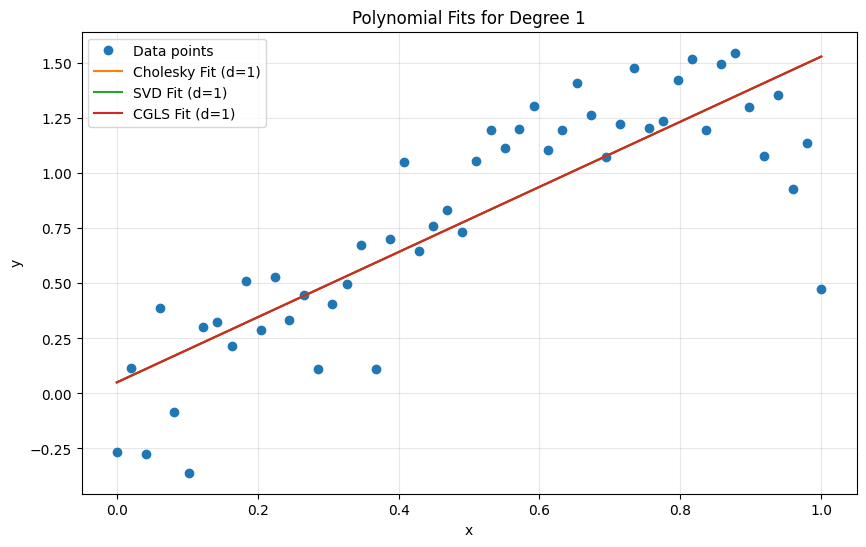

Residuo per d = 1: 4.089521739958081.
Residuo per d = 1: 4.089521739958083.
Residuo per d = 1: 4.089521739958081.


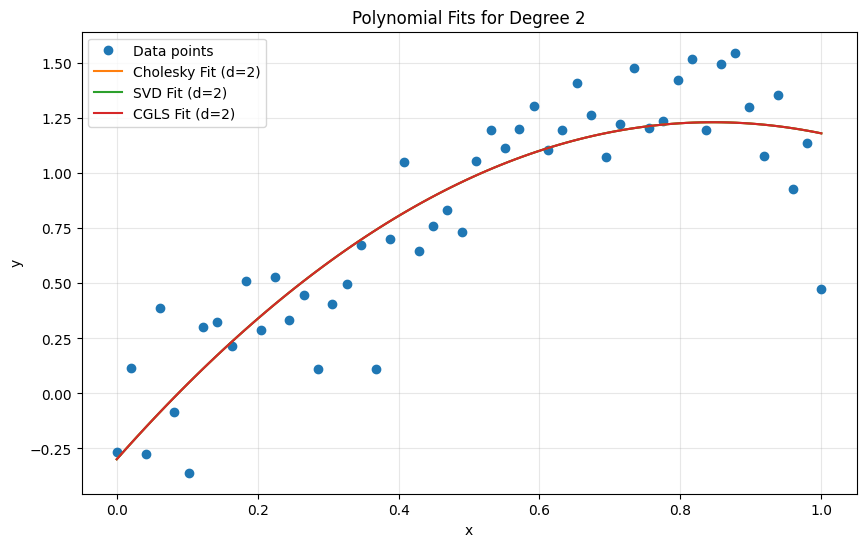

Residuo per d = 2: 2.7155199321370587.
Residuo per d = 2: 2.7155199321370587.
Residuo per d = 2: 2.7155199321370587.


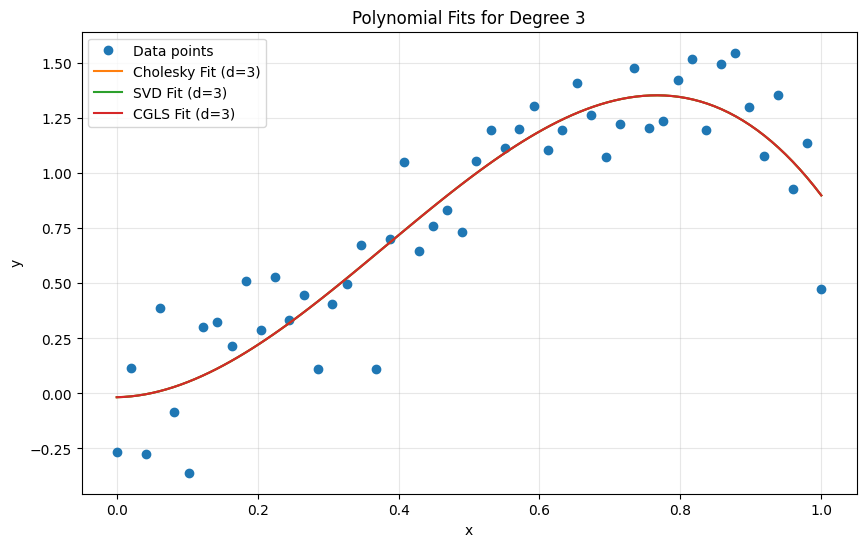

Residuo per d = 3: 1.99416020602434.
Residuo per d = 3: 1.9941602060243404.
Residuo per d = 3: 1.99416020602434.


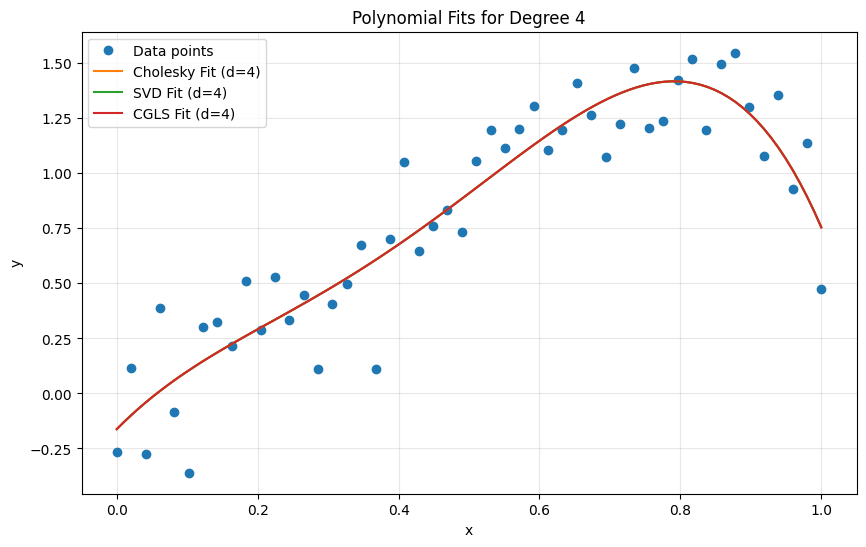

Residuo per d = 4: 1.8195076802967096.
Residuo per d = 4: 1.819507680296712.
Residuo per d = 4: 1.8195076802967145.


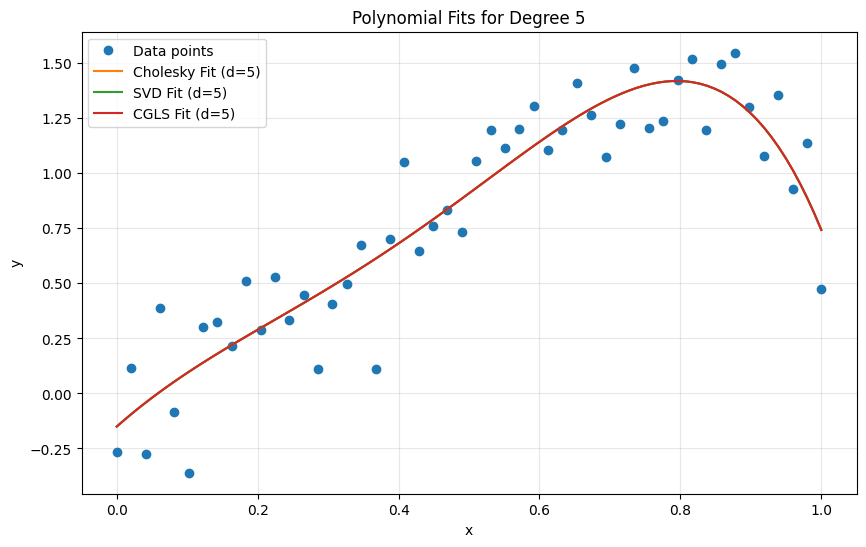

Residuo per d = 5: 1.8183483742325601.
Residuo per d = 5: 1.8183483742325612.
Residuo per d = 5: 1.8183483742325606.


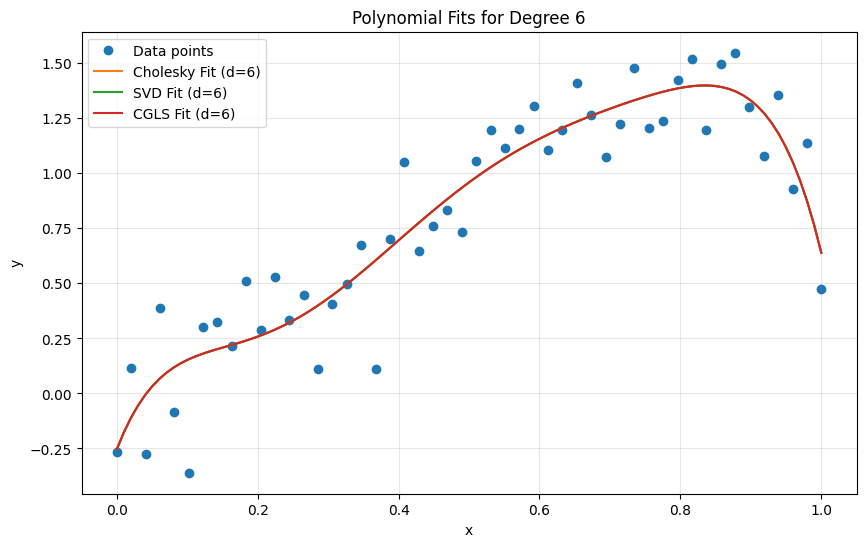

Residuo per d = 6: 1.722179336872233.
Residuo per d = 6: 1.7221793368722467.
Residuo per d = 6: 1.7221793368722416.


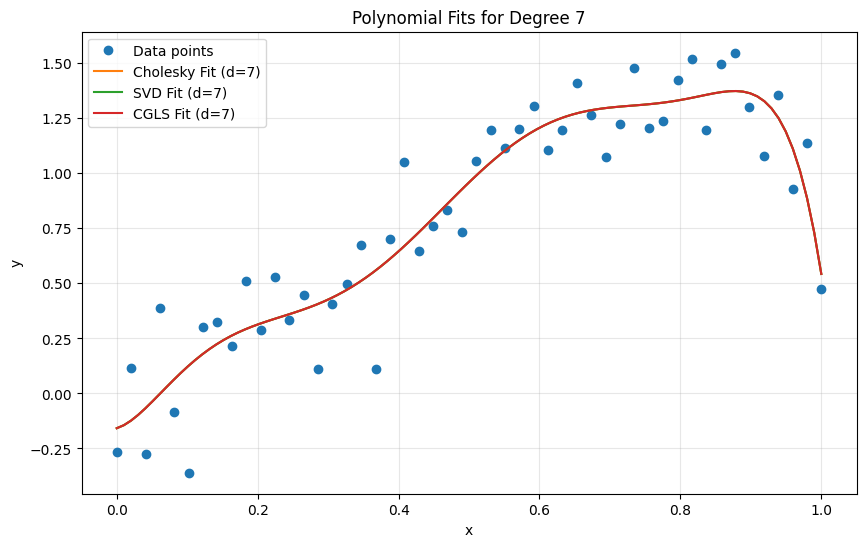

Residuo per d = 7: 1.627144991803184.
Residuo per d = 7: 1.6271449918030652.
Residuo per d = 7: 1.6271449918027976.


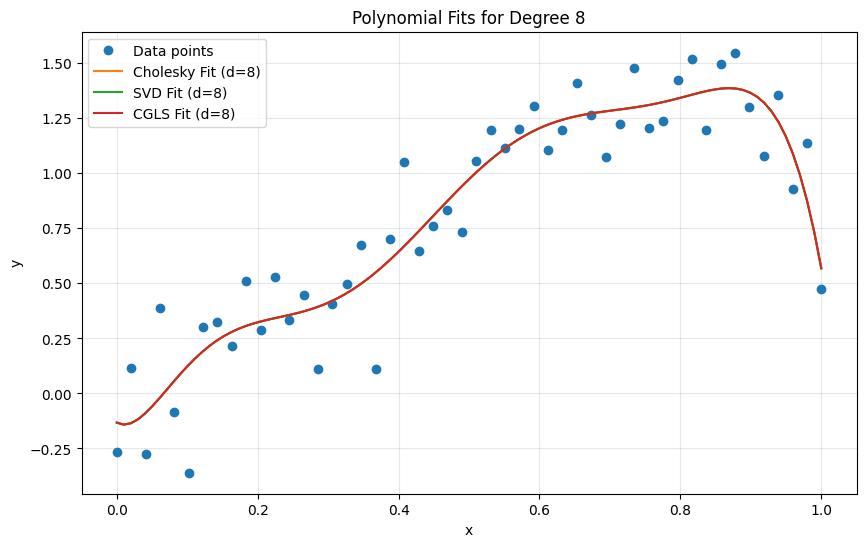

Residuo per d = 8: 1.6189873682095195.
Residuo per d = 8: 1.6189873682098315.
Residuo per d = 8: 1.6189873682095421.


In [271]:
max_degree = 8
cholesky_results = []
svd_results = []
cgls_results = []

for d in range(1, max_degree + 1):
    X = vandermonde(x, d)

    cholesky_result, _ = solve_cholesky_timed(X, y)
    svd_result, _ = solve_svd_timed(X, y, d)
    cgls_result, _ = solve_cgls_timed(X, y)
    
    cholesky_results.append(cholesky_result)
    svd_results.append(svd_result)
    cgls_results.append(cgls_result)
    
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, "o", label="Data points")
    plt.plot(xx, np.polyval(cholesky_result[::-1], xx), label=f"Cholesky Fit (d={d})")
    plt.plot(xx, np.polyval(svd_result[::-1], xx), label=f"SVD Fit (d={d})")
    plt.plot(xx, np.polyval(cgls_result[::-1], xx), label=f"CGLS Fit (d={d})")
    plt.grid(alpha=0.3)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Polynomial Fits for Degree {d}")
    plt.legend()
    plt.show()
    
    print(f"Residuo per d = {d}: {residuo(X, y, cholesky_result)}.")
    print(f"Residuo per d = {d}: {residuo(X, y, svd_result)}.")
    print(f"Residuo per d = {d}: {residuo(X, y, cgls_result)}.")

Osserviamo come il valore del residuo è molto grande quando $ d $ è piccolo per poi scendere rapidamente quanado ci si avvicina al valore esatto. Per identificare l'overfit non è semplice quando l'undefit, il residuo può continuare a scendere anche dopo il valore ottimale, questo comportamento deriva dal fatto che il modello ha iniziato a interpolare il rumore.

Passiamo al punto successivo e impostiamo $ d = 6 $ e il problema ai minimi quadrati regolarizzato con Tikhonov,

  $$
  \min_{\alpha\in\R^{d+1}} \frac{1}{2}\| X\alpha - y \|_2^2 + \frac{\lambda}{2}\| Lx \|_2^2
  $$

  con $ L $ matrice identità, e $ \lambda > 0 $ parametro di regolarizzazione.

In [272]:
d_reg: int = 6
X6: np.ndarray = vandermonde(x, d_reg)

L: np.ndarray = np.eye(d_reg + 1)
lambdas: list[float] = [0.001, 0.01, 0.1, 1, 10]

#### 1. Cholesky

In [273]:
def solve_cholesky_reg(X: np.ndarray, y: np.ndarray, L: np.ndarray, lmbda: float) -> np.ndarray:
    """
    Risolve usando la decomposizione di Cholesky con regolarizzazione di Tikhonov.
    
    Parameters:
    X (np.ndarray): Matrice delle caratteristiche (features).
    y (np.ndarray): Vettore delle risposte (target).
    L (np.ndarray): Matrice di regolarizzazione.
    lmbda (float): Parametro di regolarizzazione.
    
    Returns:
    np.ndarray: Vettore dei pesi (coefficients) della regressione lineare regolarizzata.
    """
    A = X.T @ X + lmbda * (L.T @ L)
    
    rank = np.linalg.matrix_rank(A)
    if rank < A.shape[1]:
        raise ValueError("La matrice A non ha rango pieno.")
    
    L = np.linalg.cholesky(A)
    b = X.T @ y

    z = np.linalg.solve(L, b)
    x = np.linalg.solve(L.T, z)

    return x

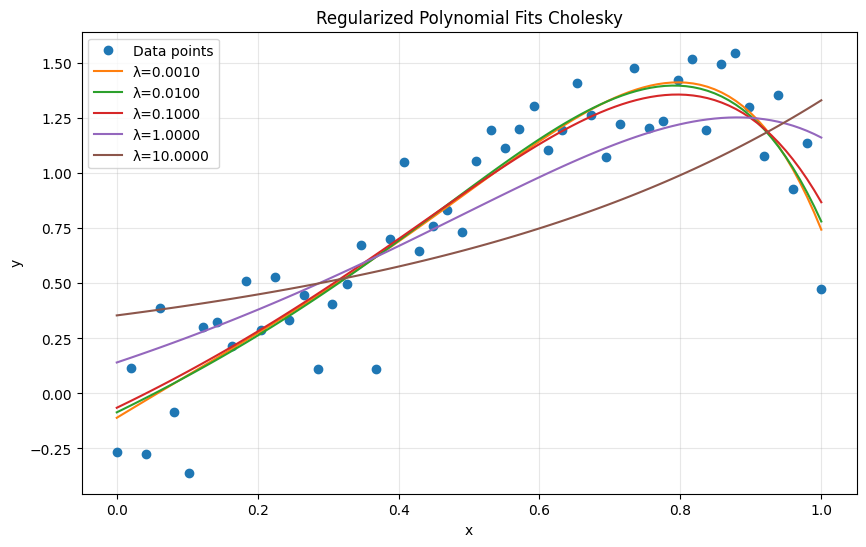

In [274]:
cholesky_results_reg: np.ndarray = []

plt.figure(figsize=(10, 6))
plt.plot(x, y, "o", label="Data points")

for lmbda in lambdas:
    alpha = solve_cholesky_reg(X6, y, L, lmbda)
    cholesky_results_reg.append(alpha)

    plt.plot(xx, np.polyval(alpha[::-1], xx), label=f"λ={lmbda:.4f}")
    1
plt.grid(alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Regularized Polynomial Fits Cholesky")
plt.legend()
plt.show()

#### 2. SVD

In [275]:
def solve_svd_reg(X: np.ndarray, y: np.ndarray, L: np.ndarray, lmbda: float) -> np.ndarray:
    """
    Risolve usando la decomposizione SVD con regolarizzazione di Tikhonov.
    
    Parameters:
    X (np.ndarray): Matrice delle caratteristiche (features).
    y (np.ndarray): Vettore delle risposte (target).
    L (np.ndarray): Matrice di regolarizzazione.
    lmbda (float): Parametro di regolarizzazione.
    
    Returns:
    np.ndarray: Vettore dei pesi (coefficients) della regressione lineare regolarizzata.
    """
    U, s, VT = np.linalg.svd(X, full_matrices=False)
    x = np.zeros(X.shape[1])

    LtL = L.T @ L
    for i in range(X.shape[1]):
        uTy = U[:, i].T @ y
        vi = VT[i, :]
        si2 = s[i]**2 + lmbda * (vi @ LtL @ vi)
        x += (uTy / si2) * s[i] * vi
    
    return x

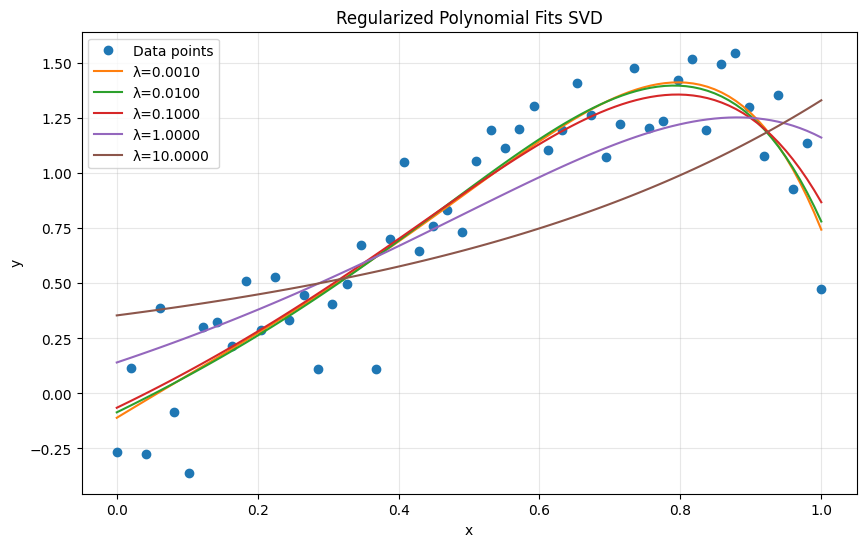

In [276]:
svd_results_reg: np.ndarray = []

plt.figure(figsize=(10, 6))
plt.plot(x, y, "o", label="Data points")

for lmbda in lambdas:
    alpha = solve_svd_reg(X6, y, L, lmbda)
    svd_results_reg.append(alpha)

    plt.plot(xx, np.polyval(alpha[::-1], xx), label=f"λ={lmbda:.4f}")

plt.grid(alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Regularized Polynomial Fits SVD")
plt.legend()
plt.show()

#### 3. CGLS

In [277]:
def solve_cgls_reg(X: np.ndarray, y: np.ndarray, L: np.ndarray, lmbda: float, atol: float = TOL, max_iter: int = MAX_ITER) -> np.ndarray:
    """
    Risolve usando il metodo Conjugate Gradient Least Squares (CGLS) con regolarizzazione di Tikhonov.
    
    Parameters:
    X (np.ndarray): Matrice delle caratteristiche (features).
    y (np.ndarray): Vettore delle risposte (target).
    L (np.ndarray): Matrice di regolarizzazione.
    lmbda (float): Parametro di regolarizzazione.
    tol (float): Tolleranza per la convergenza.
    max_iter (int): Numero massimo di iterazioni.
    
    Returns:
    np.ndarray: Vettore dei pesi (coefficients) della regressione lineare regolarizzata.
    """
    m, n = X.shape
    x = np.zeros(n)
    r = y - X @ x
    s = X.T @ r - lmbda * (L.T @ (L @ x))
    p = s.copy()
    norm_r0 = np.linalg.norm(r)
    eps = 1e-15
    
    for k in range(max_iter):
        q = X @ p
        t = L @ p
        alpha = (s.T @ s) / (q.T @ q + lmbda * (t.T @ t) + eps)
        x = x + alpha * p
        r = r - alpha * q
        s_new = X.T @ r - lmbda * (L.T @ (L @ x))

        if np.linalg.norm(r) < atol * norm_r0:
            print(f"CGLS with regularization converged in {k+1} iterations.")
            break
        
        beta = (s_new.T @ s_new) / (s.T @ s + eps)
        p = s_new + beta * p
        s = s_new
        
    return x

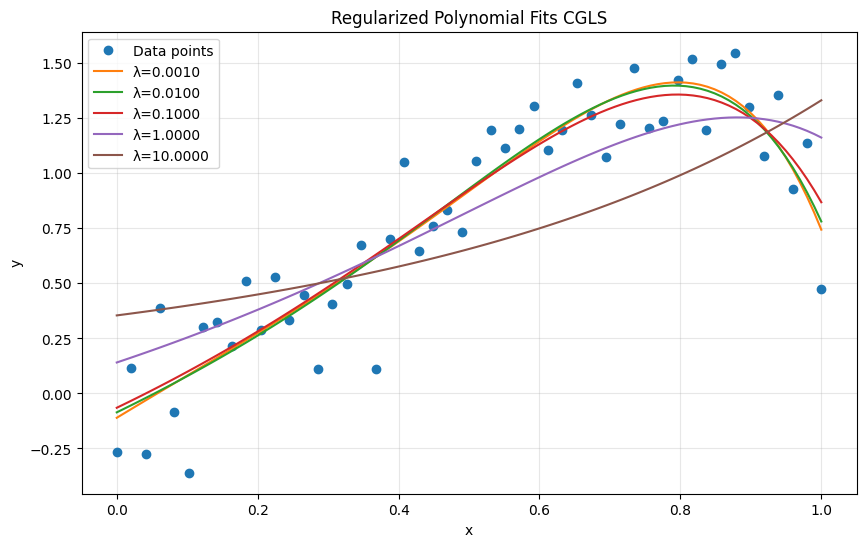

In [278]:
cgls_results_reg: np.ndarray = []

plt.figure(figsize=(10, 6))
plt.plot(x, y, "o", label="Data points")

for lmbda in lambdas:
    alpha = solve_cgls_reg(X6, y, L, lmbda)
    cgls_results_reg.append(alpha)
    
    plt.plot(xx, np.polyval(alpha[::-1], xx), label=f"λ={lmbda:.4f}")

plt.grid(alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Regularized Polynomial Fits CGLS")
plt.legend()
plt.show()

variamo $ d $ dopo aver scelto $ \alpha=0.1 $. È il valore di mezzo che sembra più ottimale visivamente.

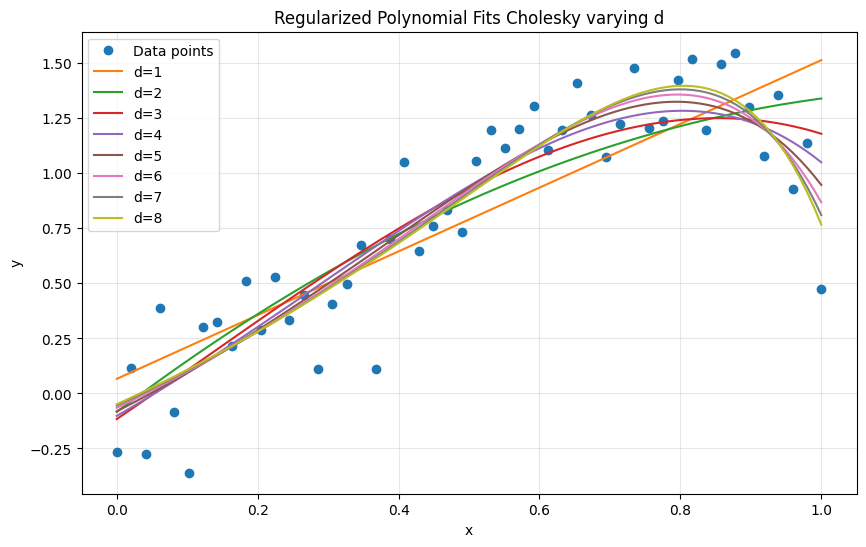

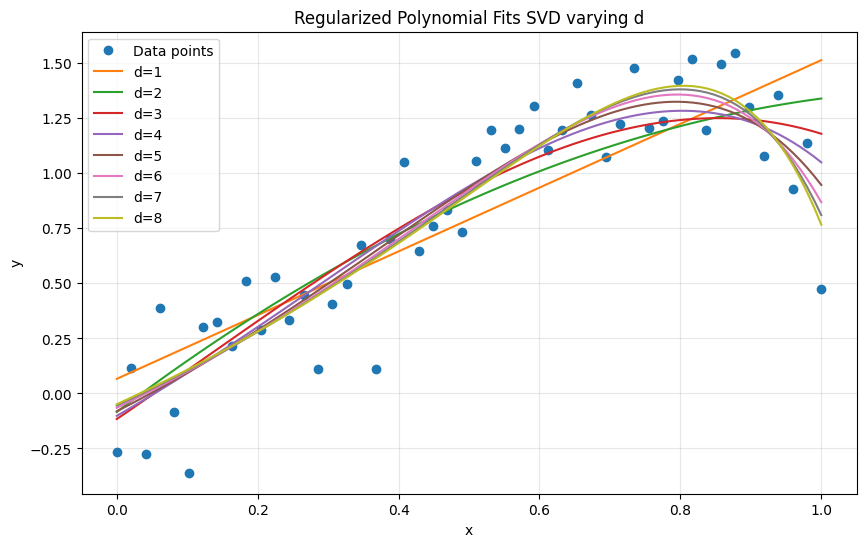

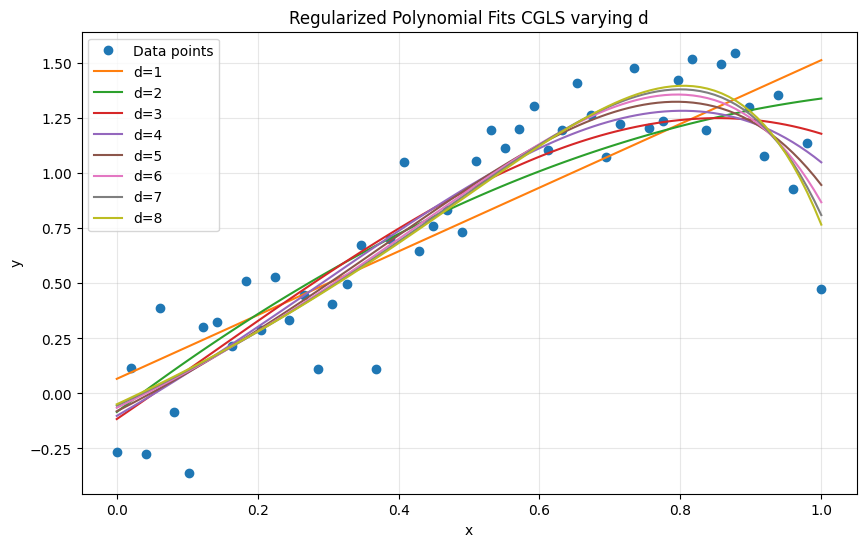

In [279]:
lmbda: float = 0.1

cholesky_results_d: np.ndarray = []
svd_results_d: np.ndarray = []
cgls_results_d: np.ndarray = []

for d in range(1, 9):
    X = vandermonde(x, d)
    L = np.eye(d + 1)
    cholesky_result = solve_cholesky_reg(X, y, L, lmbda)
    svd_result = solve_svd_reg(X, y, L, lmbda)
    cgls_result = solve_cgls_reg(X, y, L, lmbda)

    cholesky_results_d.append(cholesky_result)
    svd_results_d.append(svd_result)
    cgls_results_d.append(cgls_result)

plt.figure(figsize=(10, 6))
plt.plot(x, y, "o", label="Data points")

for d in range(1, 9):
    plt.plot(xx, np.polyval(cholesky_results_d[d-1][::-1], xx), label=f"d={d}")

plt.grid(alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Regularized Polynomial Fits Cholesky varying d")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x, y, "o", label="Data points")

for d in range(1, 9):
    plt.plot(xx, np.polyval(svd_results_d[d-1][::-1], xx), label=f"d={d}")
    
plt.grid(alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Regularized Polynomial Fits SVD varying d")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x, y, "o", label="Data points")

for d in range(1, 9):
    plt.plot(xx, np.polyval(cgls_results_d[d-1][::-1], xx), label=f"d={d}")
    
plt.grid(alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Regularized Polynomial Fits CGLS varying d")
plt.legend()
plt.show()
    


Ripetiamo ora l’esperimento utilizzando come matrice di Tikhonov $L$ (di dimensione $ n \times n$, dove $n$ è uguale al numero di elementi di $ x $), che ha tutti valori $ 1 $ sulla diagonale, e valori $ -1 $ sulla sovra-diagonale.

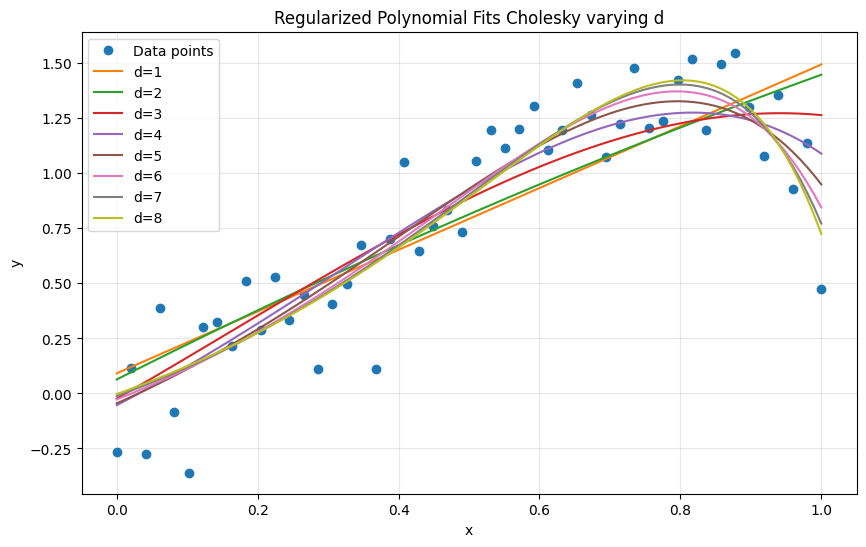

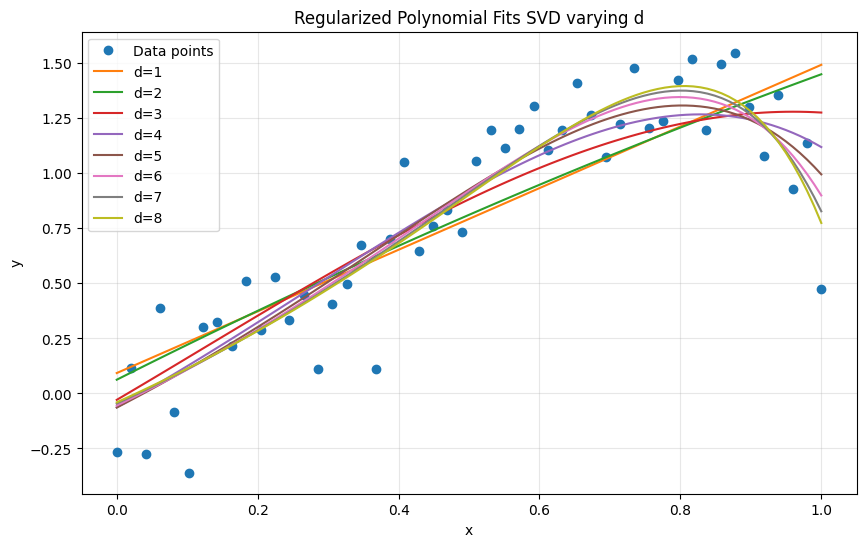

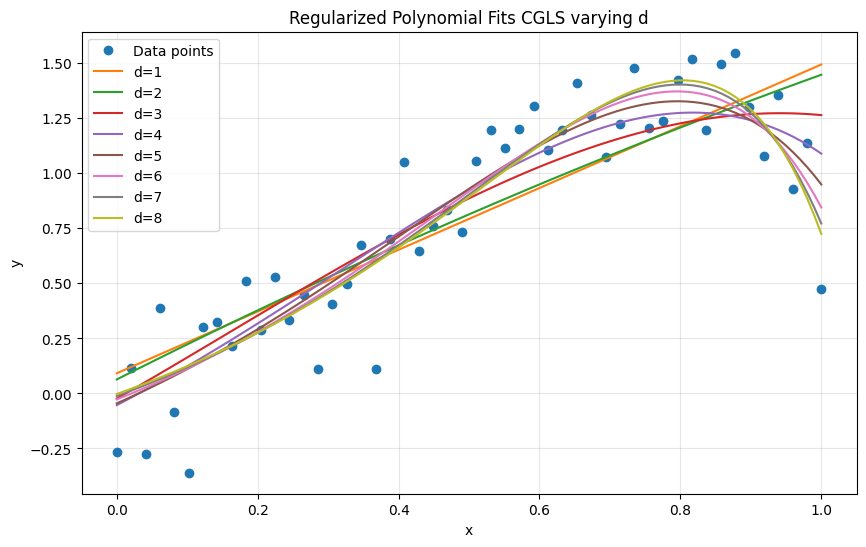

In [280]:
cholesky_results_L: np.ndarray = []
svd_results_L: np.ndarray = []
cgls_results_L: np.ndarray = []

for d in range(1, 9):
    X = vandermonde(x, d)
    L = np.eye(d + 1)
    
    for i in range(d):
        L[i, i+1] = -1
    
    cholesky_result = solve_cholesky_reg(X, y, L, lmbda)
    svd_result = solve_svd_reg(X, y, L, lmbda)
    cgls_result = solve_cgls_reg(X, y, L, lmbda)

    cholesky_results_L.append(cholesky_result)
    svd_results_L.append(svd_result)
    cgls_results_L.append(cgls_result)

plt.figure(figsize=(10, 6))
plt.plot(x, y, "o", label="Data points")

for d in range(1, 9):
    plt.plot(xx, np.polyval(cholesky_results_L[d-1][::-1], xx), label=f"d={d}")

plt.grid(alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Regularized Polynomial Fits Cholesky varying d")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x, y, "o", label="Data points")

for d in range(1, 9):
    plt.plot(xx, np.polyval(svd_results_L[d-1][::-1], xx), label=f"d={d}")

plt.grid(alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Regularized Polynomial Fits SVD varying d")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x, y, "o", label="Data points")

for d in range(1, 9):
    plt.plot(xx, np.polyval(cgls_results_L[d-1][::-1], xx), label=f"d={d}")
    
plt.grid(alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Regularized Polynomial Fits CGLS varying d")
plt.legend()
plt.show()

Sappiamo ora che d_true = 4 e alpha_true = np.array([0, 0, 4, 0, -3]). Definisco la funzione per calcolare l'errore relativo.


 misurare (per alcuni degli esperimenti fatti sopra (i più promettenti)) l’errore relativo tra il valore di alpha calcolato e alpha_true, e confrontare visivamente su grafico i polinomi approssimanti rispetto al polinomio reale (senza rumore) ottenuto tramite alpha_true. Commentare i risultati ottenuti.

In [ ]:
d_true: int = 4
alpha_true: np.ndarray = np.array([0, 0, 4, 0, -3])

def relative_error(x: np.ndarray, x_true: np.ndarray) -> float:
    return np.linalg.norm(x - x_true) / np.linalg.norm(x_true)

Prendiamo i risultati ottenuti applicando i metodi senza regolarizzazione.

In [282]:
i: int = d_true -1

err_cholesky = relative_error(cholesky_results[i], alpha_true)
err_svd = relative_error(svd_results[i], alpha_true)
err_cgls = relative_error(cgls_results[i], alpha_true)

Andiamo a cercare l'alpha migliore, in termini di errore relativo minimo, negli array contenenti i risultati regolarizzati con Tikhonov, al variare del $\lambda$. Facciamo un piccolo padding su alpha_true per poter confrontare i risultati calcolati con $d=6$.

In [284]:
alpha_true6 = [0, 0, 4, 0, -3, 0, 0]

err_cholesky_reg = [relative_error(alpha, alpha_true6) for alpha in cholesky_results_reg]
err_svd_reg = [relative_error(alpha, alpha_true6) for alpha in svd_results_reg]
err_cgls_reg = [relative_error(alpha, alpha_true6) for alpha in cgls_results_reg]

best_lambda_cholesky = lambdas[np.argmin(err_cholesky_reg)]
best_lambda_svd = lambdas[np.argmin(err_svd_reg)]
best_lambda_cgls = lambdas[np.argmin(err_cgls_reg)]

Il migliore alpha al variare di $d$ fissato $\lambda=0.1$ miglire alpha con matrice $L$.

In [285]:
err_cholesky_d = relative_error(cholesky_results_d[i], alpha_true)
err_svd_d = relative_error(svd_results_d[i], alpha_true)
err_cgls_d = relative_error(cgls_results_d[i], alpha_true)

err_cholesky_L = relative_error(cholesky_results_L[i], alpha_true)
err_svd_L = relative_error(svd_results_L[i], alpha_true)
err_cgls_L = relative_error(cgls_results_L[i], alpha_true)

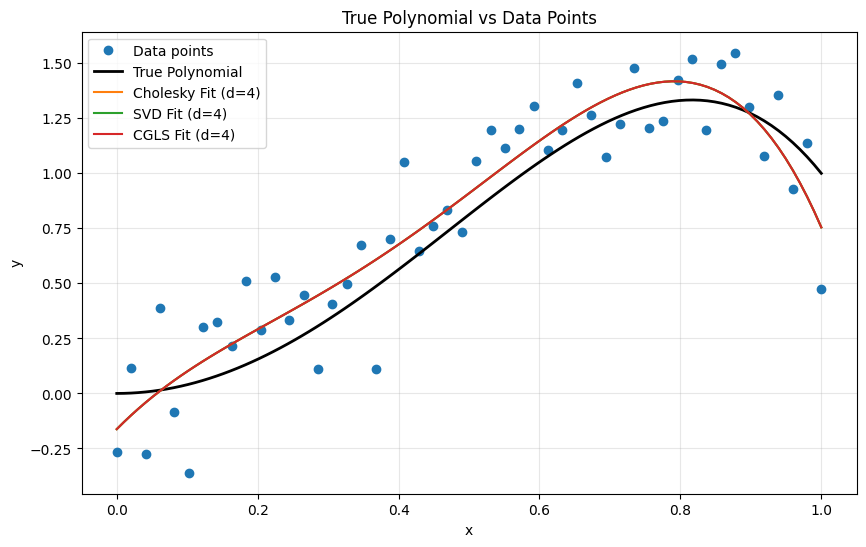

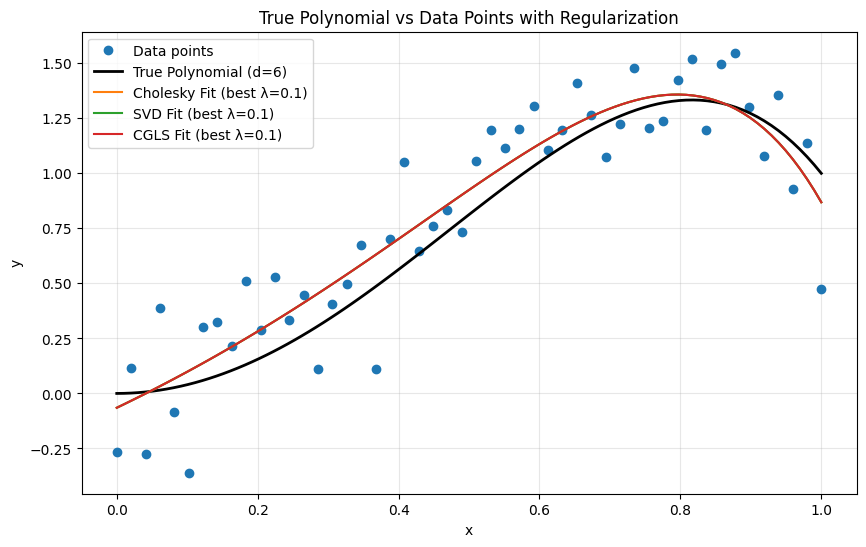

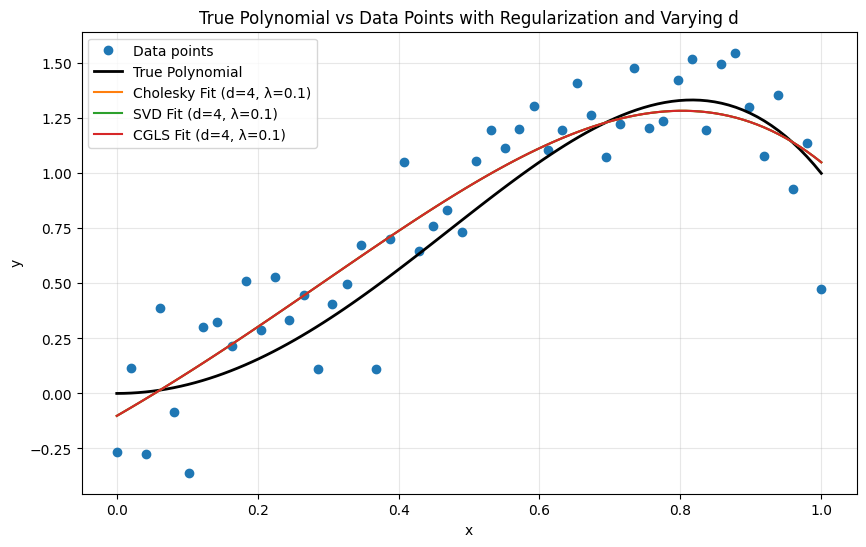

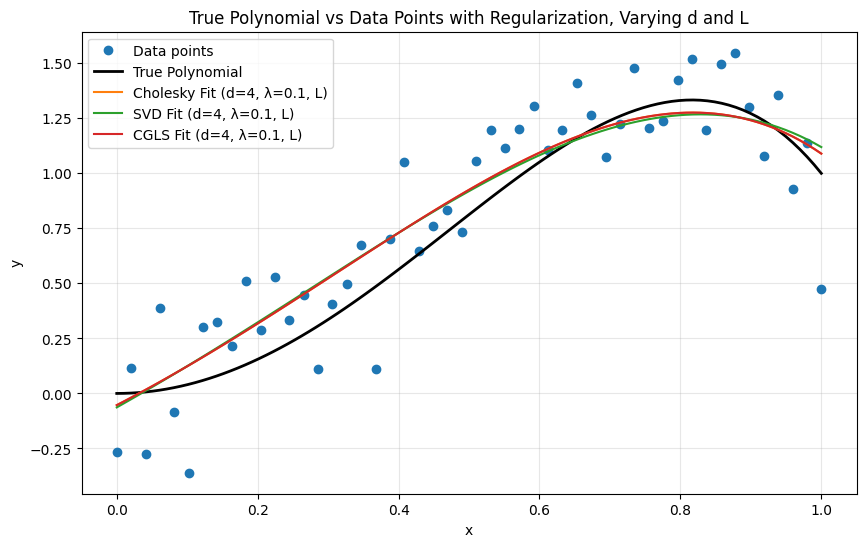

,Metodo,Errore (al variare di d),Errore (al variare di λ),λ Migliore,"Errore reg (al variare di d, λ=0.1)","Errore reg L (al variare di d, λ=0.1)"
0,Cholesky,4.533171,0.917121,0.1,0.785753,0.763063
1,SVD,4.533171,0.917121,0.1,0.785753,0.843449
2,CGLS,4.533171,0.917121,0.1,0.785753,0.763063


In [299]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, "o", label="Data points")
plt.plot(xx, np.polyval(alpha_true[::-1], xx), label="True Polynomial", color="black", linewidth=2)
plt.plot(xx, np.polyval(cholesky_results[i][::-1], xx), label=f"Cholesky Fit (d={d_true})")
plt.plot(xx, np.polyval(svd_results[i][::-1], xx), label=f"SVD Fit (d={d_true})")
plt.plot(xx, np.polyval(cgls_results[i][::-1], xx), label=f"CGLS Fit (d={d_true})")

plt.grid(alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.title("True Polynomial vs Data Points")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x, y, "o", label="Data points")
plt.plot(xx, np.polyval(alpha_true6[::-1], xx), label="True Polynomial (d=6)", color="black", linewidth=2)
plt.plot(xx, np.polyval(cholesky_results_reg[np.argmin(err_cholesky_reg)][::-1], xx), label=f"Cholesky Fit (best λ={best_lambda_cholesky})")
plt.plot(xx, np.polyval(svd_results_reg[np.argmin(err_svd_reg)][::-1], xx), label=f"SVD Fit (best λ={best_lambda_svd})")
plt.plot(xx, np.polyval(cgls_results_reg[np.argmin(err_cgls_reg)][::-1], xx), label=f"CGLS Fit (best λ={best_lambda_cgls})")
plt.grid(alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.title("True Polynomial vs Data Points with Regularization")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x, y, "o", label="Data points")
plt.plot(xx, np.polyval(alpha_true[::-1], xx), label="True Polynomial", color="black", linewidth=2)
plt.plot(xx, np.polyval(cholesky_results_d[i][::-1], xx), label=f"Cholesky Fit (d={d_true}, λ={lmbda})")
plt.plot(xx, np.polyval(svd_results_d[i][::-1], xx), label=f"SVD Fit (d={d_true}, λ={lmbda})")
plt.plot(xx, np.polyval(cgls_results_d[i][::-1], xx), label=f"CGLS Fit (d={d_true}, λ={lmbda})")
plt.grid(alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.title("True Polynomial vs Data Points with Regularization and Varying d")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x, y, "o", label="Data points")
plt.plot(xx, np.polyval(alpha_true[::-1], xx), label="True Polynomial", color="black", linewidth=2)
plt.plot(xx, np.polyval(cholesky_results_L[i][::-1], xx), label=f"Cholesky Fit (d={d_true}, λ={lmbda}, L)")
plt.plot(xx, np.polyval(svd_results_L[i][::-1], xx), label=f"SVD Fit (d={d_true}, λ={lmbda}, L)")
plt.plot(xx, np.polyval(cgls_results_L[i][::-1], xx), label=f"CGLS Fit (d={d_true}, λ={lmbda}, L)")
plt.grid(alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.title("True Polynomial vs Data Points with Regularization, Varying d and L")
plt.legend()
plt.show()

errors_table = pd.DataFrame({
    "Metodo": ["Cholesky", "SVD", "CGLS"],
    "Errore (al variare di d)": [err_cholesky, err_svd, err_cgls],
    "Errore (al variare di λ)": [min(err_cholesky_reg), min(err_svd_reg), min(err_cgls_reg)],
    "λ Migliore": [best_lambda_cholesky, best_lambda_svd, best_lambda_cgls],
    "Errore reg (al variare di d, λ=0.1)": [err_cholesky_d, err_svd_d, err_cgls_d],
    "Errore reg L (al variare di d, λ=0.1)": [err_cholesky_L, err_svd_L, err_cgls_L]
})

errors_table

Nei risultati senza regolarizzazione, tutti i metodi mostrano un errore molto alto. 

Utilizzando la regolatrizzazione di Tikhonov possiamo notare che la stavbilità migliora significativamente. In particolare, fissando il grado $d=6$ e variando $\lambda$ si osserva che il valore ottimale è $\lambda=0.1$.

Successivamente mantenendo il $\lambda=0.1$ e riducendo il grado a $d=4$ l'errore si riduce ulteriormente, questo conferma l'efficacia della regolarizzazione nel migliorare la qualità del fitting.

Infine sostituendo la matrice di penalizzazione con la matrice $L$ (con diagonali pari a 1 e valori -1 sulla sovradiagonale), si nota un comportamento diverso tra i metodi: la struttura della matrice stabilizza Cholesky e CGLS, riducendo leggermente l'errore, ma non SVD, che peggiora. La scelta della matrice quindi può influire diversamente a seconda del metodo utilizzato.

### Ottimizzazione con Discesa Gradiente

Utilizzando il metodo di Discesa del Gradiente (GD) visto a lezione, risolvere il problema di minimo:
$$
\min_{x\in\R^n} f(x)
$$
per le seguenti funzioni $ f(x) $:

1. $ f: \R^2 \rightarrow \R $ tale che:
  $$
  f(x_1, x_2)=(x_1-3)^2+(x_2-1)^2
  $$
  con soluzione esatta $ x_{true} = (3, 1) $

2. $ f: \R^2 \rightarrow \R $ tale che:
  $$
  f(x_1, x_2)=10(x_1-1)^2+(x_2-2)^2
  $$
  con soluzione esatta $ x_{true} = (1, 2) $

3. $ f: \R \rightarrow \R $ tale che:
  $$
  f(x)=x^4+x^3-2x^2-2x
  $$
  con soluzione esatta $ x_{true} = 0.92222 $

1. Per ognuna delle funzioni sopra, utilizzare sia il metodo GD con passo fisso sia utilizzando backtracking, provando vari valori del passo $ \alpha > 0 $ nel caso in cui non si utilizzi backtracking. Utilizza maxit = 100, tolf = tolx = 1e-6. Per le funzioni 1. e 2., scegliere x0 come vettore di zeri. Confrontare le soluzioni ottenute con e senza backtracking in termini di tempo di esecuzione e velocità di convergenza (misurata in termini di numero di iterazioni richieste per convergere).

2. Visualizzare su un grafico il valore di $ \| \nabla f(x_k) \|_2 $ sia per la soluzione con backtracking sia per alcuni valori di $ \alpha $, e commenta su quale metodo performa meglio e perché. La soluzione con backtracking è sempre più veloce di quella con passo fisso?

3. Visualizzare su un grafico il valore dell’errore relativo $ RE(x_{true}, x_k) $ sia per la soluzione con backtracking sia per alcuni valori di $ \alpha $, e commenta i risultati ottenuti.

4. Fare un plot della funzione 3. nell’intervallo $ [-3, 3] $, cosa osservi? Provare ad eseguire il metodo GD con e senza backtracking variando il valore di x0. Cosa osservi?

5. Opzionale (Diffile): Fare un contour plot delle funzioni 1. e 2. (vedi documentazione per plt.contour) e visualizza, sullo stesso grafico, il percorso generato dall’algoritmo GD. In particolare, rappresentare sul grafico bi-dimensionale la posizione di tutti gli iterati $ x_k $ dell’algoritmo GD, collegati da un segmento, così da controllare il diverso comportamento di GD quando si utilizza o meno il backtracking.

#### SOLUZIONE:



Partiamo col definire inanzitutto le funzioni e le loro derivate (calcolate a mano per maggiore efficienza).

In [345]:
def f1(x):
    return (x[0] - 3)**2 + (x[1] - 1)**2

def df1(x):
    return np.array([2 * (x[0] - 3), 2 * (x[1] - 1)])

def f2(x):
    return 10 * (x[0] - 1)** 2 + (x[1] - 2)** 2

def df2(x):
    return np.array([20 * (x[0] - 1), 2 * (x[1] - 2)])

def f3(x):
    x = x.item()
    return x**4 + x**3 - 2 * x**2 - 2 * x

def df3(x):
    x = x.item()
    return np.array([4 * x**3 + 3 * x**2 - 4 * x - 2])

x_true_f1 = np.array([3, 1])
x_true_f2 = np.array([1, 2])
x_true_f3 = np.array([0.92222])

Andiamo a definire le funzioni che implementano la discesa del gradiente con passo fisso e il backtracking.

In [386]:
def GD(f, df, x0, x_true, alpha, maxit=100, tolf=1e-6, tolx=1e-6, path_flag=False) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Implementa il metodo di discesa del gradiente con passo fisso applicato ad una funzione f(x) della quale si conosce la derivata df(x). 

    Parameters:
    f (function): la funzione obiettivo che si vuole minimizzare.
    df (function): la derivata (o gradiente) della funzione obiettivo.
    x0 (ndarray): valore iniziale dell'algoritmo.
    x_true (ndarray): la soluzione esatta dell'algoritmo (nota SOLO in fase di test).
    alpha (float): il passo fisso che descrive gli step dell'algoritmo.
    maxit (int): numero di iterazioni.
    tolf (float): tolleranza di || grad(f) ||_2.
    tolx (float): tolleranza di || x_{k+1} - x_k ||_2.
    
    Returns:
    tuple: (x, rel_err, obj_val, grad_norm, k)  e path se path_flag=True.
    """
    k = 0
    rel_err = np.zeros((maxit+1, ))
    obj_val = np.zeros((maxit+1, ))
    grad_norm = np.zeros((maxit+1, ))
    condizione = True

    if path_flag:
        path = [x0]
    
    while condizione:
        x = x0 - alpha * df(x0)

        if path_flag:
            path.append(x)
        
        rel_err[k] = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        obj_val[k] = f(x)
        grad_norm[k] = np.linalg.norm(df(x))
        
        condizione = (k < maxit) and (np.linalg.norm(df(x)) > tolf) and (np.linalg.norm(x - x0) > tolx)
        
        if (np.linalg.norm(x - x0) < tolx):
            print(f"Algoritmo terminato per condizione su tolx.")
        
        k = k + 1
        x0 = x

    if k < maxit:
        rel_err = rel_err[:k]
        obj_val = obj_val[:k]
        grad_norm = grad_norm[:k]

    if path_flag:
        return path
    else:
        return x, rel_err, obj_val, grad_norm, k

def backtracking(f, df, x, alpha=1, rho=0.5, c=1e-4) -> float:
    """
    Algoritmo di backtracking per Discesa Gradiente.

    Parameters:
    f (function): Funzione obiettivo.
    df (function): Gradiente della funzione obiettivo.
    x (ndarray): Iterato x_k.
    alpha (float): Stima iniziale di alpha.
    rho (float): Fattore di riduzione.
    c (float): Costante delle condizioni di Armijo.

    Returns:
    alpha   : Learning rate calcolato con backtracking.
    """
    while f(x - alpha * df(x)) > f(x) - c * alpha * np.linalg.norm(df(x))**2:
        alpha *= rho
    return alpha

def GD_backtracking(f, df, x0, x_true, maxit=100, tolf=1e-6, tolx=1e-6, path_flag=False) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Implementa il metodo di discesa del gradiente con passo scelto con backtracking applicato ad una funzione f(x) della quale si conosce la derivata df(x). 

    Parameters:
    f (function): la funzione obiettivo che si vuole minimizzare.
    df (function): la derivata (o gradiente) della funzione obiettivo.
    x0 (ndarray): valore iniziale dell'algoritmo.
    x_true (ndarray): la soluzione esatta dell'algoritmo (nota SOLO in fase di test).
    maxit (int): numero di iterazioni.
    tolf (float): tolleranza di || grad(f) ||_2.
    tolx (float): tolleranza di || x_{k+1} - x_k ||_2.
    
    Returns:
    tuple: (x, rel_err, obj_val, grad_norm, k) o path se path_flag=True.
    """
    k = 0
    rel_err = np.zeros((maxit+1, ))
    obj_val = np.zeros((maxit+1, ))
    grad_norm = np.zeros((maxit+1, ))
    condizione = True

    if path_flag:
        path = [x0]

    while condizione:
        alpha = backtracking(f, df, x0, alpha=1)
        x = x0 - alpha * df(x0)

        if path_flag:
            path.append(x)

        rel_err[k] = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        obj_val[k] = f(x)
        grad_norm[k] = np.linalg.norm(df(x))

        condizione = (k < maxit) and (np.linalg.norm(df(x)) > tolf) and (np.linalg.norm(x - x0) > tolx)

        if (np.linalg.norm(x - x0) < tolx):
            print(f"Algoritmo terminato per condizione su tolx.")
        
        k = k + 1
        x0 = x
        
    if k < maxit:
        rel_err = rel_err[:k]
        obj_val = obj_val[:k]
        grad_norm = grad_norm[:k]

    if path_flag:
        return path
    else:
        return x, rel_err, obj_val, grad_norm, k


##### 1.
Andiamo ad applicare il metodo GD con passo fisso e il metodo che sfrutta il backtracking. Definiamo prima i seguenti valori:
* MAXIT = 100
* TOLF = TOLX = 1e-6
* x0 = vettore di zeri

In [335]:
MAXIT = 100
TOLF = TOLX = 1e-6
x0: np.ndarray = np.array([0, 0])
x0_f3: np.ndarray = np.array([0])

In [ ]:
def timed(func):
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        elapsed_time = time.perf_counter() - start_time
        return result, elapsed_time
    return wrapper

GD_timed = timed(GD)
GD_backtracking_timed = timed(GD_backtracking)

##### 1.1 Funzione 1

In [361]:
alphas: list[float] = [1e-1, 1e-2, 1e-3]
f1_alphas: list = []

for alpha in alphas:
    result, elapsed_time = GD_timed(f1, df1, x0, x_true_f1, alpha, maxit=MAXIT, tolf=TOLF, tolx=TOLX)
    x, rel_err, obj_val, grad_norm, k = result
    
    f1_alphas.append({
        'x': x,
        'rel_err': rel_err,
        'obj_val': obj_val,
        'grad_norm': grad_norm,
        'k': k,
        'time': elapsed_time,
        'alpha': alpha
    })

f1_backtracking: list = []
result, elapsed_time = GD_backtracking_timed(f1, df1, x0, x_true_f1, maxit=MAXIT, tolf=TOLF, tolx=TOLX)
x, rel_err, obj_val, grad_norm, k = result

f1_backtracking.append({
    'x': x,
    'rel_err': rel_err,
    'obj_val': obj_val,
    'grad_norm': grad_norm,
    'k': k,
    'time': elapsed_time
})

# Tabella di confronto
comparison: list = []

for f1_alpha in f1_alphas:
    comparison.append({
        'Metodo': f'GD (alpha={f1_alpha["alpha"]})',
        'x': f1_alpha['x'],
        'Tempo di esecuzione': f1_alpha['time'],
        'Iterazioni': f1_alpha['k']
    })

comparison.append({
    'Metodo': 'GD con backtracking',
    'x': f1_backtracking[0]['x'],
    'Tempo di esecuzione': f1_backtracking[0]['time'],
    'Iterazioni': f1_backtracking[0]['k']
})

comparison_table = pd.DataFrame(comparison)
comparison_table

Algoritmo terminato per condizione su tolx.


,Metodo,x,Tempo di esecuzione,Iterazioni
0,GD (alpha=0.1),"[2.9999963220107015, 0.9999987740035673]",0.002284,61
1,GD (alpha=0.01),"[2.6100985056694257, 0.870032835223142]",0.002466,101
2,GD (alpha=0.001),"[0.549210986762847, 0.1830703289209491]",0.002094,101
3,GD con backtracking,"[3.0, 1.0]",0.000111,1


##### 1.2 Funzione 2

In [362]:
alphas: list[float] = [0.09, 1e-2, 1e-3]
f2_alphas: list = []

for alpha in alphas:
    result, elapsed_time = GD_timed(f2, df2, x0, x_true_f2, alpha, maxit=MAXIT, tolf=TOLF, tolx=TOLX)
    x, rel_err, obj_val, grad_norm, k = result

    f2_alphas.append({
        'x': x,
        'rel_err': rel_err,
        'obj_val': obj_val,
        'grad_norm': grad_norm,
        'k': k,
        'time': elapsed_time,
        'alpha': alpha
    })

f2_backtracking: list = []
result, elapsed_time = GD_backtracking_timed(f2, df2, x0, x_true_f2, maxit=MAXIT, tolf=TOLF, tolx=TOLX)
x, rel_err, obj_val, grad_norm, k = result

f2_backtracking.append({
    'x': x,
    'rel_err': rel_err,
    'obj_val': obj_val,
    'grad_norm': grad_norm,
    'k': k,
    'time': elapsed_time
})

# Tabella di confronto
comparison: list = []

for f2_alpha in f2_alphas:
    comparison.append({
        'Metodo': f'GD (alpha={f2_alpha["alpha"]})',
        'x': f2_alpha['x'],
        'Tempo di esecuzione': f2_alpha['time'],
        'Iterazioni': f2_alpha['k']
    })

comparison.append({
    'Metodo': 'GD con backtracking',
    'x': f2_backtracking[0]['x'],
    'Tempo di esecuzione': f2_backtracking[0]['time'],
    'Iterazioni': f2_backtracking[0]['k']
})

comparison_table = pd.DataFrame(comparison)
comparison_table

Algoritmo terminato per condizione su tolx.
Algoritmo terminato per condizione su tolx.


,Metodo,x,Tempo di esecuzione,Iterazioni
0,GD (alpha=0.09),"[0.9999997428899128, 1.9999972434113873]",0.002218,68
1,GD (alpha=0.01),"[0.9999999998370371, 1.740065670446284]",0.001973,101
2,GD (alpha=0.001),"[0.870032835223142, 0.3661406578418982]",0.002310,101
3,GD con backtracking,"[1.000000310038351, 1.9999981600305703]",0.003907,55


##### 1.3 Funzione 3

In [363]:
alphas: list[float] = [0.2, 0.1, 1e-2]
f3_alphas: list = []

for alpha in alphas:
    result, elapsed_time = GD_timed(f3, df3, x0_f3, x_true_f3, alpha, maxit=MAXIT, tolf=TOLF, tolx=TOLX)
    x, rel_err, obj_val, grad_norm, k = result

    f3_alphas.append({
        'x': x,
        'rel_err': rel_err,
        'obj_val': obj_val,
        'grad_norm': grad_norm,
        'k': k,
        'time': elapsed_time,
        'alpha': alpha
    })

f3_backtracking: list = []
result, elapsed_time = GD_backtracking_timed(f3, df3, x0_f3, x_true_f3, maxit=MAXIT, tolf=TOLF, tolx=TOLX)
x, rel_err, obj_val, grad_norm, k = result

f3_backtracking.append({
    'x': x,
    'rel_err': rel_err,
    'obj_val': obj_val,
    'grad_norm': grad_norm,
    'k': k,
    'time': elapsed_time
})

# Tabella di confronto
comparison: list = []

for f3_alpha in f3_alphas:
    comparison.append({
        'Metodo': f'GD (alpha={f3_alpha["alpha"]})',
        'x': f3_alpha['x'],
        'Tempo di esecuzione': f3_alpha['time'],
        'Iterazioni': f3_alpha['k']
    })

comparison.append({
    'Metodo': 'GD con backtracking',
    'x': f3_backtracking[0]['x'],
    'Tempo di esecuzione': f3_backtracking[0]['time'],
    'Iterazioni': f3_backtracking[0]['k']
})

comparison_table = pd.DataFrame(comparison)
comparison_table

Algoritmo terminato per condizione su tolx.
Algoritmo terminato per condizione su tolx.


,Metodo,x,Tempo di esecuzione,Iterazioni
0,GD (alpha=0.2),[0.6069533290162585],0.004511,101
1,GD (alpha=0.1),[0.922224841451033],0.000458,11
2,GD (alpha=0.01),[0.922192364854019],0.003555,101
3,GD con backtracking,[0.9222245820435584],0.001413,18


In tutte e tre le funzioni si osserva che la soluzione ottenuta con il metodo di GD con passo fisso è molto sensibile alla scelta di $\alpha$. Se $\alpha$ è scelto bene il metodo converge rapidamente alla soluzione corretta, se inece $\alpha$ è troppo piccolo la convergenza diventa molto lenta e può non raggiunge il punto di minimo entro il numero massimo di iterazioni.

Al contrario il metodo del backtracking riesce sempre ad adattare il passo in base alla funzione e porta la soluzione molto vicino a $x_{true}$.

In termini di tempo di esecuzione, il metodo di GD con passo fisso è più veloce per singola iterazione ma rischia di richiedere più iterazioni se $\alpha$ è scelto male. Con il backtracking ogni iterazione è più costosa perhé deve determinare il passo corretto ma porta spesso a una convergenza affidabile in meno iterazioni.

##### 2.
Analizziamo la norma euclidea del gradiente.

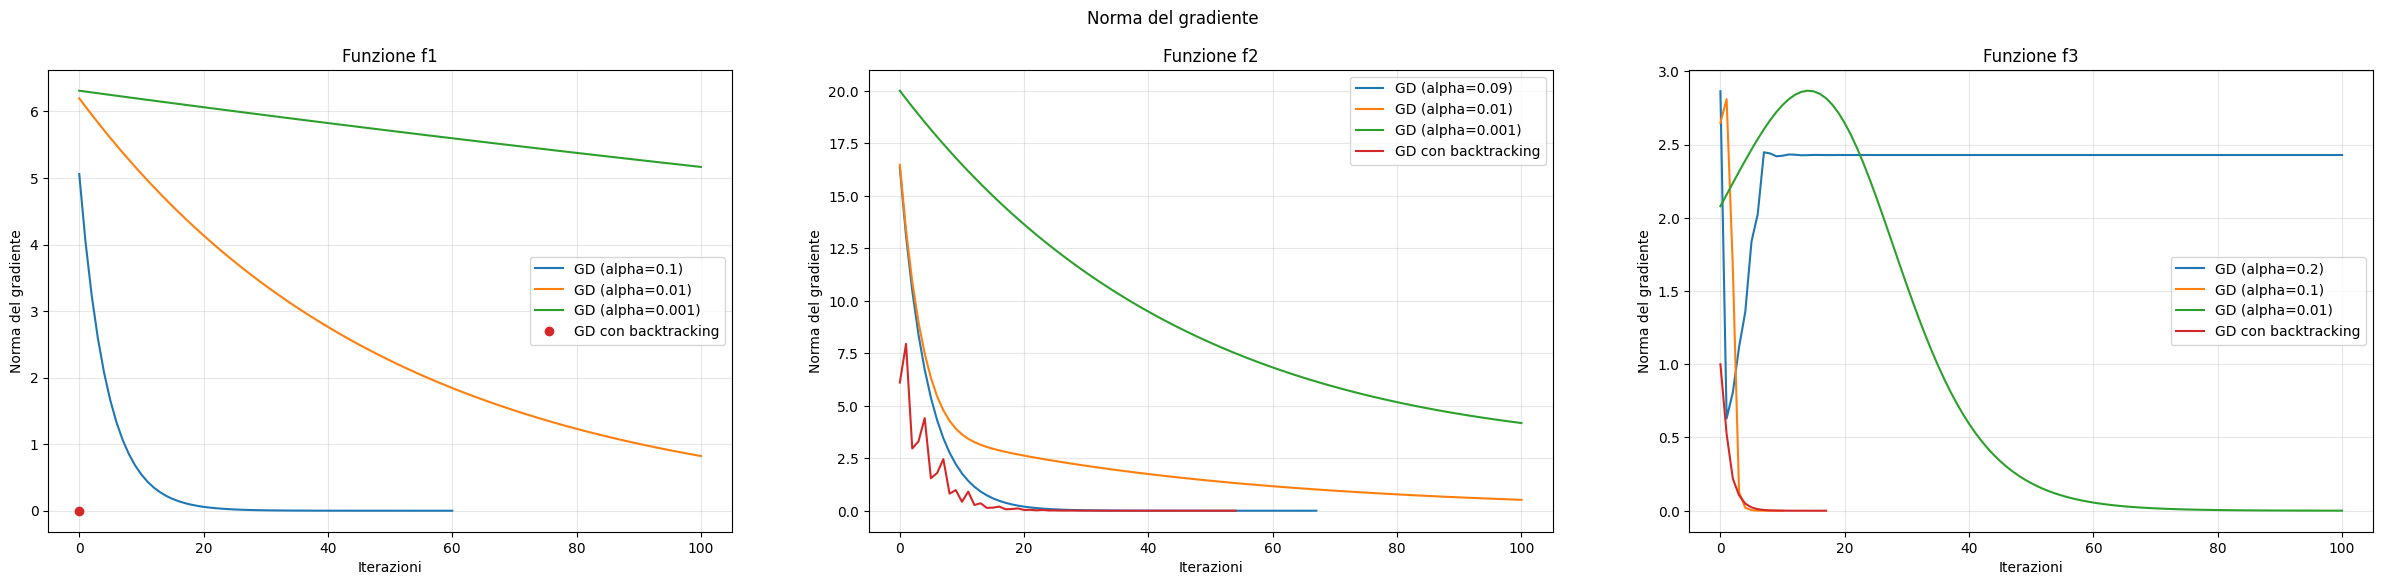

In [364]:
plt.figure(figsize=(30, 6))
plt.suptitle('Norma del gradiente')

plt.subplot(1, 3, 1)
for f1_alpha in f1_alphas:
    plt.plot(np.arange(len(f1_alpha['grad_norm'])), f1_alpha['grad_norm'], label=f'GD (alpha={f1_alpha["alpha"]})')
plt.plot(np.arange(len(f1_backtracking[0]['grad_norm'])), f1_backtracking[0]['grad_norm'], 'o', label='GD con backtracking')
plt.xlabel('Iterazioni')
plt.ylabel('Norma del gradiente')
plt.title('Funzione f1')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
for f2_alpha in f2_alphas:
    plt.plot(np.arange(len(f2_alpha['grad_norm'])), f2_alpha['grad_norm'], label=f'GD (alpha={f2_alpha["alpha"]})')
plt.plot(np.arange(len(f2_backtracking[0]['grad_norm'])), f2_backtracking[0]['grad_norm'], label='GD con backtracking')
plt.xlabel('Iterazioni')
plt.ylabel('Norma del gradiente')
plt.title('Funzione f2')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
for f3_alpha in f3_alphas:
    plt.plot(np.arange(len(f3_alpha['grad_norm'])), f3_alpha['grad_norm'], label=f'GD (alpha={f3_alpha["alpha"]})')
plt.plot(np.arange(len(f3_backtracking[0]['grad_norm'])), f3_backtracking[0]['grad_norm'], label='GD con backtracking')
plt.xlabel('Iterazioni')
plt.ylabel('Norma del gradiente')
plt.title('Funzione f3')
plt.legend()
plt.grid(alpha=0.3)

plt.show()

La norma euclidea del gradiente $\|\nabla f(x_k)\|_2$ misura in poche parole la "pendenza" della funzione, quando ha un valore alto vuol dire che la funzone è "ripida" e quindi c'è un margine di miglioramento, quando ha un valore basso vuol dire che siamo vicini a un punto stazionatio.

In tutte e tre le funzioni osserviamo che il metodo GD con backtracking riesce quasi sempre a raggiungere il punto di minimo più velocemente del metodo con passo fisso, l'unica eccezione è nella funzione 3 con $\alpha=0.1$. Nella prima funzione addirittura converge in una sola iterazione.

##### 3.
Analizziamo l'errore relativo.

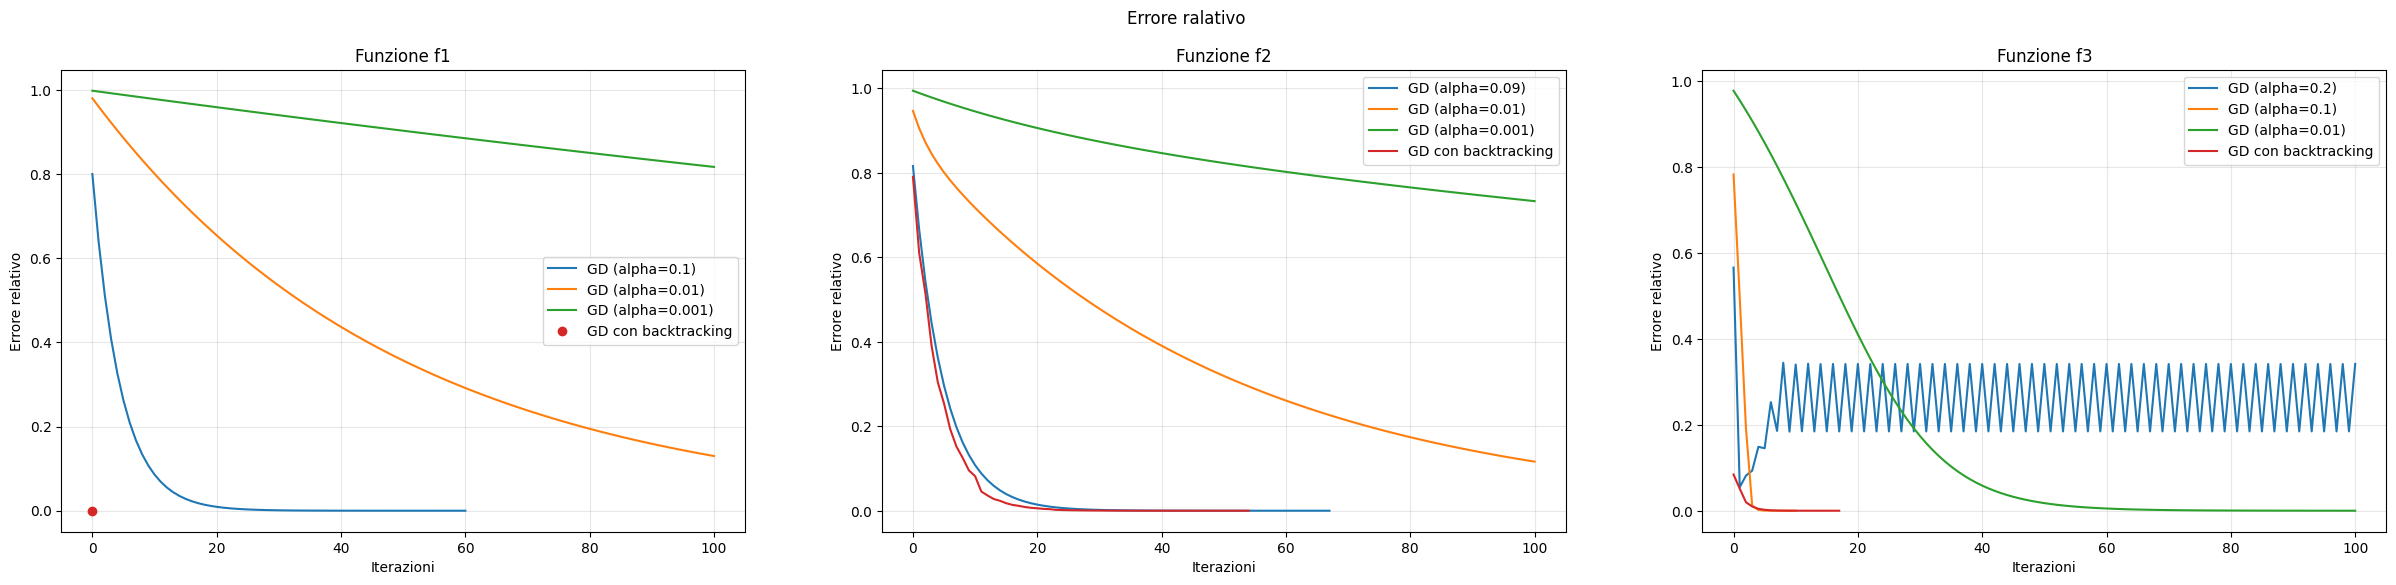

In [365]:
plt.figure(figsize=(30, 6))
plt.suptitle('Errore ralativo')

plt.subplot(1, 3, 1)
for f1_alpha in f1_alphas:
    plt.plot(np.arange(len(f1_alpha['rel_err'])), f1_alpha['rel_err'], label=f'GD (alpha={f1_alpha["alpha"]})')
plt.plot(np.arange(len(f1_backtracking[0]['rel_err'])), f1_backtracking[0]['rel_err'], 'o', label='GD con backtracking')
plt.xlabel('Iterazioni')
plt.ylabel('Errore relativo')
plt.title('Funzione f1')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
for f2_alpha in f2_alphas:
    plt.plot(np.arange(len(f2_alpha['rel_err'])), f2_alpha['rel_err'], label=f'GD (alpha={f2_alpha["alpha"]})')
plt.plot(np.arange(len(f2_backtracking[0]['rel_err'])), f2_backtracking[0]['rel_err'], label='GD con backtracking')
plt.xlabel('Iterazioni')
plt.ylabel('Errore relativo')
plt.title('Funzione f2')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
for f3_alpha in f3_alphas:
    plt.plot(np.arange(len(f3_alpha['rel_err'])), f3_alpha['rel_err'], label=f'GD (alpha={f3_alpha["alpha"]})')
plt.plot(np.arange(len(f3_backtracking[0]['rel_err'])), f3_backtracking[0]['rel_err'], label='GD con backtracking')
plt.xlabel('Iterazioni')
plt.ylabel('Errore relativo')
plt.title('Funzione f3')
plt.legend()
plt.grid(alpha=0.3)

plt.show()

L'errore relativo misura quanto la soluzione attuale è vicina a $x_{true}$, utile se conosciamo la soluzione esatta.

I grafici riportati con l'errore relativo confermano quanto detto prima sul metodo con il backtracking, che si riconferma il metodo più rapido. È interessante notare il comportamento dell'errore relativo nella funzione 3 con $\alpha=0.2$, essa non diminuisce in modo stabile ma oscilla senza convergere, questo succede quando la scelta del passo è troppo grande rispetto alla curvatura della funzione, il metodo del gradiente rimbalza attorno al punto di minimo senza avvicinarsi.

##### 4.
Plottiamo la funzione 3 nell’intervallo $ [-3, 3] $,

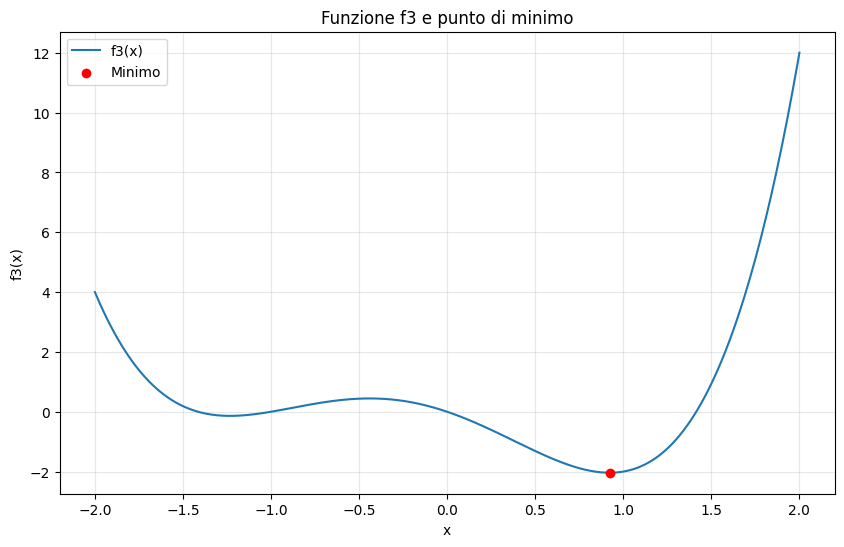

In [417]:
xx = np.linspace(-2, 2, 400)
yy = np.array([f3(np.array([x])) for x in xx])

plt.figure(figsize=(10, 6))
plt.plot(xx, yy, label='f3(x)')
plt.scatter(x_true_f3, f3(x_true_f3), color='red', label='Minimo', zorder=5)
plt.xlabel('x')
plt.ylabel('f3(x)')
plt.title('Funzione f3 e punto di minimo')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Notiamo che la funzione ha due punti di minimo.

Applichiamo il metodo GD con e senza backtracking variando il valore di x0. Fissiamo $\lambda=0.1$ siccome è quello che precedentemente ha prodotto risultati più soddisfacenti.

Algoritmo terminato per condizione su tolx.
Algoritmo terminato per condizione su tolx.
Algoritmo terminato per condizione su tolx.
Algoritmo terminato per condizione su tolx.
Algoritmo terminato per condizione su tolx.
Algoritmo terminato per condizione su tolx.
Algoritmo terminato per condizione su tolx.
Algoritmo terminato per condizione su tolx.


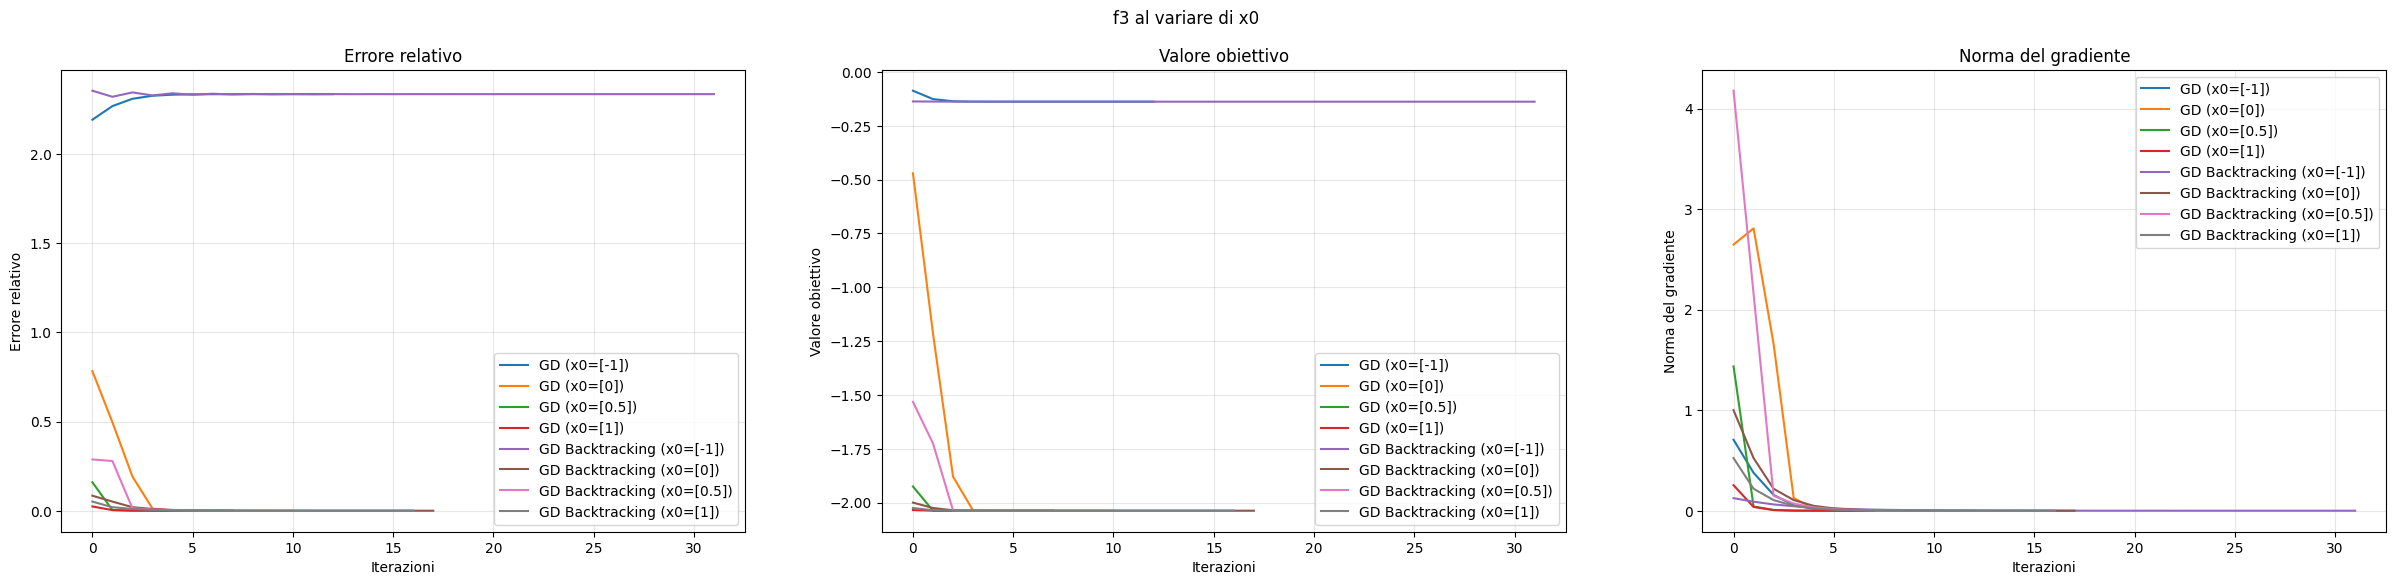

,Metodo,x,Tempo di esecuzione,Iterazioni
0,GD (x0=[-1]),[-1.2322393372416245],0.002906,13
1,GD (x0=[0]),[0.922224841451033],0.000534,11
2,GD (x0=[0.5]),[0.9222246955904424],0.000252,8
3,GD (x0=[1]),[0.9222248827552759],0.000261,8
4,GD Backtracking (x0=[-1]),[-1.232239226028443],0.003117,32
5,GD Backtracking (x0=[0]),[0.9222245820435584],0.001278,18
6,GD Backtracking (x0=[0.5]),[0.9222250978391288],0.001210,17
7,GD Backtracking (x0=[1]),[0.9222245820435584],0.001222,17


In [377]:
alpha: float = 0.1
x0s: list = [np.array([-1]), np.array([0]), np.array([0.5]), np.array([1])]

f3_x0s = []
f3_backtracking_x0s = []

for x0 in x0s:
    result, elapsed_time = GD_timed(f3, df3, x0, x_true_f3, alpha, maxit=MAXIT, tolf=TOLF, tolx=TOLX)
    x, rel_err, obj_val, grad_norm, k = result

    f3_x0s.append({
        'x': x,
        'rel_err': rel_err,
        'obj_val': obj_val,
        'grad_norm': grad_norm,
        'k': k,
        'time': elapsed_time,
        'x0': x0
    })

    result, elapsed_time = GD_backtracking_timed(f3, df3, x0, x_true_f3, maxit=MAXIT, tolf=TOLF, tolx=TOLX)
    x, rel_err, obj_val, grad_norm, k = result

    f3_backtracking_x0s.append({
        'x': x,
        'rel_err': rel_err,
        'obj_val': obj_val,
        'grad_norm': grad_norm,
        'k': k,
        'time': elapsed_time,
        'x0': x0
    })

plt.figure(figsize=(30, 6))
plt.suptitle('f3 al variare di x0')

plt.subplot(1, 3, 1)
for f3_x0 in f3_x0s:
    plt.plot(np.arange(len(f3_x0['rel_err'])), f3_x0['rel_err'], label=f'GD (x0={f3_x0["x0"]})')
for f3_backtracking_x0 in f3_backtracking_x0s:
    plt.plot(np.arange(len(f3_backtracking_x0['rel_err'])), f3_backtracking_x0['rel_err'], label=f'GD Backtracking (x0={f3_backtracking_x0["x0"]})')
plt.xlabel('Iterazioni')
plt.ylabel('Errore relativo')
plt.title('Errore relativo')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
for f3_x0 in f3_x0s:
    plt.plot(np.arange(len(f3_x0['obj_val'])), f3_x0['obj_val'], label=f'GD (x0={f3_x0["x0"]})')
for f3_backtracking_x0 in f3_backtracking_x0s:
    plt.plot(np.arange(len(f3_backtracking_x0['obj_val'])), f3_backtracking_x0['obj_val'], label=f'GD Backtracking (x0={f3_backtracking_x0["x0"]})')
plt.xlabel('Iterazioni')
plt.ylabel('Valore obiettivo')
plt.title('Valore obiettivo')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
for f3_x0 in f3_x0s:
    plt.plot(np.arange(len(f3_x0['grad_norm'])), f3_x0['grad_norm'], label=f'GD (x0={f3_x0["x0"]})')
for f3_backtracking_x0 in f3_backtracking_x0s:
    plt.plot(np.arange(len(f3_backtracking_x0['grad_norm'])), f3_backtracking_x0['grad_norm'], label=f'GD Backtracking (x0={f3_backtracking_x0["x0"]})')
plt.xlabel('Iterazioni')
plt.ylabel('Norma del gradiente')
plt.title('Norma del gradiente')
plt.legend()
plt.grid(alpha=0.3)

plt.show()

comparison = []

for f3_x0 in f3_x0s:
    comparison.append({
        'Metodo': f'GD (x0={f3_x0["x0"]})',
        'x': f3_x0['x'],
        'Tempo di esecuzione': f3_x0['time'],
        'Iterazioni': f3_x0['k']
    })

for f3_backtracking_x0 in f3_backtracking_x0s:
    comparison.append({
        'Metodo': f'GD Backtracking (x0={f3_backtracking_x0["x0"]})',
        'x': f3_backtracking_x0['x'],
        'Tempo di esecuzione': f3_backtracking_x0['time'],
        'Iterazioni': f3_backtracking_x0['k']
    })

comparison_table = pd.DataFrame(comparison)
comparison_table

Possiamo notare che quando impostiamo x0 = -1 i metodi convergono attorno a -1,23 mentre quando impostiamo x0 = 0, 0,5, 1 i metodi convergono vicino a 0.9222, questo suggerisce che f3 ha almeno due minimi locali e l'algoritmo si ferma in quello più vicino al punto iniziale.

Dato che il learning rate è stato fissato a 0.1 (valore che abbiamo visto prima era la più ottimale) possiamo osservare che in questo caso il GD classico converge più rapidamente rispetto a quello con backtracking. Questo accade perché il backtracking deve fare più tentativi per la scelta del passo. 

##### 5.

Algoritmo terminato per condizione su tolx.
Algoritmo terminato per condizione su tolx.
Algoritmo terminato per condizione su tolx.


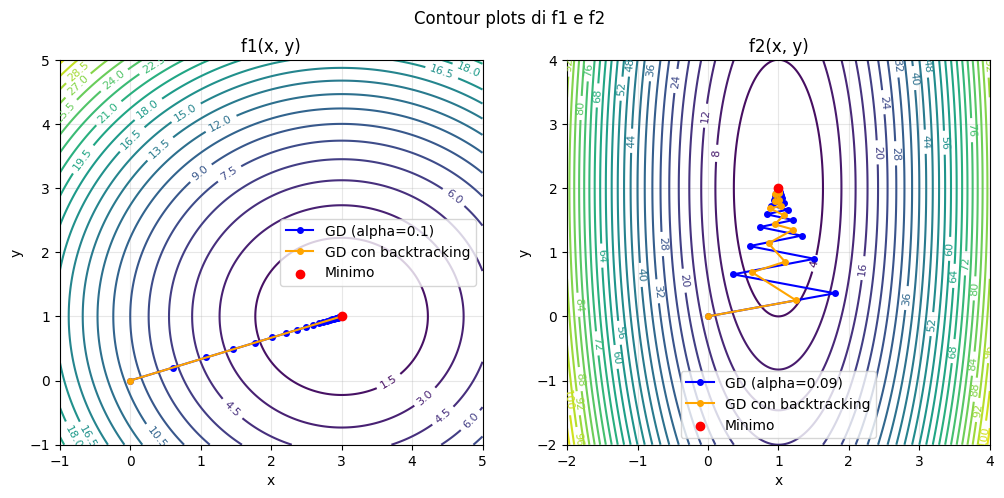

In [404]:
xx1 = np.linspace(-1, 5, 400)
yy1 = np.linspace(-1, 5, 400)
X1, Y1 = np.meshgrid(xx1, yy1)

Z1 = f1(np.array([X1, Y1]))
f1_path_GD = np.array(GD(f1, df1, np.array([0, 0]), x_true_f1, 0.1, maxit=100, tolf=1e-6, tolx=1e-6, path_flag=True))
f1_path_GD_backtracking = np.array(GD_backtracking(f1, df1, np.array([0, 0]), x_true_f1, maxit=100, tolf=1e-6, tolx=1e-6, path_flag=True))

xx2 = np.linspace(-2, 4, 400)
yy2 = np.linspace(-2, 4, 400)
X2, Y2 = np.meshgrid(xx2, yy2)

Z2 = f2(np.array([X2, Y2]))
f2_path_GD = np.array(GD(f2, df2, np.array([0, 0]), x_true_f2, 0.09, maxit=100, tolf=1e-6, tolx=1e-6, path_flag=True))
f2_path_GD_backtracking = np.array(GD_backtracking(f2, df2, np.array([0, 0]), x_true_f2, maxit=100, tolf=1e-6, tolx=1e-6, path_flag=True))

plt.figure(figsize=(12, 5))
plt.suptitle('Contour plots di f1 e f2')

plt.subplot(1, 2, 1)
contour1 = plt.contour(X1, Y1, Z1, levels=30, cmap='viridis')
plt.clabel(contour1, inline=True, fontsize=8)
plt.plot(f1_path_GD[:, 0], f1_path_GD[:, 1], 'o-', color='blue', label='GD (alpha=0.1)', markersize=4)
plt.plot(f1_path_GD_backtracking[:, 0], f1_path_GD_backtracking[:, 1], 'o-', color='orange', label='GD con backtracking', markersize=4)
plt.scatter(x_true_f1[0], x_true_f1[1], color='red', label='Minimo', zorder=5)
plt.title('f1(x, y)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
contour2 = plt.contour(X2, Y2, Z2, levels=30, cmap='viridis')
plt.clabel(contour2, inline=True, fontsize=8)
plt.plot(f2_path_GD[:, 0], f2_path_GD[:, 1], 'o-', color='blue', label='GD (alpha=0.09)', markersize=4)
plt.plot(f2_path_GD_backtracking[:, 0], f2_path_GD_backtracking[:, 1], 'o-', color='orange', label='GD con backtracking', markersize=4)
plt.scatter(x_true_f2[0], x_true_f2[1], color='red', label='Minimo', zorder=5)
plt.title('f2(x, y)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(alpha=0.3)

plt.show()

Nei countour plots le linee colorate sono le curve di livello della funzione, più si avvicina al centro più basso è il valore della funzione. Il punto rosso rappresenta il punto di minimo, i cammini di GD con passo fisso sono contraddistinti dalle linee blu mentre quelle con backtracking dalle linee gialle.

Nella prima funzione notiamo che entrambi i metodi convergono in modo diretto e stabile, mentre nella seconda funzione le traiettorie sono a zig-zag, con oscillazioni più evidenti nel metodo GD a passo fisso.